# Analysing results for the ACL paper

In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

import evaluationaux as ev

from collections import Counter
from IPython.display import display
from itertools import groupby, product
from numpy import inf
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
PATH = '/project/brie/scripts_scorekeeping/'
VISDIAL = Path('generating_propositions', 'data', 'visual_dialog')
PROPS = Path(PATH, 'main_task', 'data', 'propositions')
PATH_OUTPUTS = Path(PATH, 'main_task', 'outputs')

Using the validation and test sets:

In [3]:
visdial = {}
path_visdial_val = Path(PATH, VISDIAL, 'visdial_1.0_val.json')
with open(path_visdial_val, 'r') as d:
    visdial['val']= json.load(d)
# test propositions not used on this analysis
#path_visdial_test = Path(PATH, VISDIAL, 'visdial_1.0_test.json')
#with open(path_visdial_test, 'r') as e:
#    visdial['test'] = json.load(e)

props_data = {}    
path_props_val = Path(PATH, PROPS, 'propositions_val.json')
with open(path_props_val, 'r') as f:
    props_data['val'] = json.load(f)['dialogues']
path_props_test = Path(PATH, PROPS, 'propositions_test.json')
with open(path_props_test, 'r') as f:
    props_data['test'] = json.load(f)['dialogues']

In [4]:
BOTS =  ('a', 'q')
CONTROL_TASKS =  ('none', 'rand-reps', 'null-reps')
TASKS =  ('TFxPS', 'TF', 'PS', 'PxTSFS')
BOT_VERSIONS =  ('RL-DIV', 'SL', 'ICCV-RL')

# Results on test set

Get all results on test set, over the whole set (i.e. all turns):

In [5]:
split = 'test'

In [6]:
test_results = {}
test_accs = {}
missing = 0  # a few combinations have no experiment (e.g. TF task for the questioner)
epoch = 0  # for the test set, the only inference step is saved as 0

all_datapoints = {task: [] for task in TASKS}

# embs='pmbv2', model='Deeper' as default on ev.get_data

for (bot, control_task, task, version) in product(BOTS, CONTROL_TASKS, TASKS, BOT_VERSIONS):
    try:
        test_dataset, outputs = ev.get_data(bot, task, control_task, epoch=epoch, path=PATH_OUTPUTS,
                                            split=split, bot_version=version)
        test_results[(bot, task, control_task, version)] = outputs
        test_accs[(bot, task, control_task, version)] = 100*np.mean([pred==gold for (pred, gold) in outputs.values()])
        
        all_datapoints[task].append(test_dataset.datapoints)
        
        # be sure that the loaded dataset uses the same datapoints of the experiment
        test_identifiers = ev.get_identifiers(bot, version, task, control_task, PATH_OUTPUTS, split)
        assert ev.compare_identifiers(test_dataset.datapoints, test_identifiers)
        
    except FileNotFoundError:
        test_results[(bot, task, control_task, version)] = {}
        test_accs[(bot, task, control_task, version)] = '-'
        assert bot == 'q' and task in ('TFxPS', 'TF')
        missing += 1

assert len(test_results) ==  72                    
assert len(test_accs) == 72
assert missing == 18

Sanity check, make sure that all experiments used indeed the same indexed datapoints:

In [7]:
for task in TASKS:
    assert all(x == all_datapoints[task][0] for x in all_datapoints[task])

Table with overall acc for RL-DIV: 

In [8]:
df = pd.DataFrame(columns=TASKS)

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [test_accs[bot, t, control_task, 'RL-DIV'] for t in TASKS]
df.style.set_caption("Performance on test set, all turns, RL_DIV")        
df

,TFxPS,TF,PS,PxTSFS
"a, none",62.047,71.0261,80.943089,73.064895
"a, rand-reps",35.1087,52.4828,60.353026,47.957719
"a, null-reps",37.6601,50.6126,60.256262,50.643379
"q, none",-,-,82.027030,74.350052
"q, rand-reps",-,-,59.003787,48.801033
"q, null-reps",-,-,60.182889,50.640816


A full table with overall acc for all bot versions:

In [9]:
elements = list(product(TASKS, BOT_VERSIONS))
df = pd.DataFrame(columns=[elem for elem in elements])

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [test_accs[bot, t, control_task, v] for t, v in elements]      

print(df.to_latex())
df = df.style.set_caption("Performance on test set, all turns")
df

\begin{tabular}{lllllllrrrrrr}
\toprule
{} & (TFxPS, RL-DIV) & (TFxPS, SL) & (TFxPS, ICCV-RL) & (TF, RL-DIV) & (TF, SL) & (TF, ICCV-RL) &  (PS, RL-DIV) &   (PS, SL) &  (PS, ICCV-RL) &  (PxTSFS, RL-DIV) &  (PxTSFS, SL) &  (PxTSFS, ICCV-RL) \\
\midrule
a, none      &          62.047 &     62.3303 &          61.7869 &      71.0261 &  70.9255 &       70.7999 &     80.943089 &  81.242030 &      80.791857 &         73.064895 &     73.368642 &          73.472775 \\
a, rand-reps &         35.1087 &     35.5666 &          35.1267 &      52.4828 &  51.8222 &       53.1784 &     60.353026 &  60.659977 &      60.461644 &         47.957719 &     48.655247 &          48.625770 \\
a, null-reps &         37.6601 &     37.5297 &          37.7168 &      50.6126 &  50.6075 &       50.6136 &     60.256262 &  60.246330 &      60.218454 &         50.643379 &     50.861577 &          50.620630 \\
q, none      &               - &           - &                - &            - &        - &             - &     8

,"('TFxPS', 'RL-DIV')","('TFxPS', 'SL')","('TFxPS', 'ICCV-RL')","('TF', 'RL-DIV')","('TF', 'SL')","('TF', 'ICCV-RL')","('PS', 'RL-DIV')","('PS', 'SL')","('PS', 'ICCV-RL')","('PxTSFS', 'RL-DIV')","('PxTSFS', 'SL')","('PxTSFS', 'ICCV-RL')"
"a, none",62.047023,62.330264,61.786852,71.026139,70.925531,70.799931,80.943089,81.242030,80.791857,73.064895,73.368642,73.472775
"a, rand-reps",35.108714,35.566578,35.126657,52.482842,51.822161,53.178448,60.353026,60.659977,60.461644,47.957719,48.655247,48.625770
"a, null-reps",37.660124,37.529718,37.716836,50.612620,50.607494,50.613581,60.256262,60.246330,60.218454,50.643379,50.861577,50.620630
"q, none",-,-,-,-,-,-,82.027030,83.150701,83.060346,74.350052,73.905326,74.422785
"q, rand-reps",-,-,-,-,-,-,59.003787,59.750338,60.062736,48.801033,48.325227,48.496325
"q, null-reps",-,-,-,-,-,-,60.182889,60.134828,60.153091,50.640816,50.564239,50.537645


Now overall accuracy only at datapoints at turn 5 (6-th turn when counting caption) for RL-DIV, which should be more balanced in the private/shared dimension:

In [10]:
dialogues_min_5turns = 0
total_datapoints_turn5 = 0
with open(Path(PATH, 'main_task', 'data', 'visdial_1.0_test_dialogueLens.txt'), 'r') as file:
    lines = file.readlines()
    for line in lines:
        idx, dialogue_len = line.strip('\n').split('\t')
        if int(dialogue_len) >= 6:
            n_props = len(props_data[split][idx])
            dialogues_min_5turns += 1
            total_datapoints_turn5 += n_props
print(dialogues_min_5turns)
print(total_datapoints_turn5)

4000
32360


In [11]:
test_accs_turn5 = {}

for (bot, control_task, task, version) in product(BOTS, CONTROL_TASKS, TASKS, BOT_VERSIONS):
    if test_results[(bot, task, control_task, version)]:
        
        test_identifiers = ev.get_identifiers(bot, version, task, control_task, PATH_OUTPUTS, split)
        
        # select only datapoints at turn 5
        datapoints_turn_5 = [v for k, v in test_results[(bot, task, control_task, version)].items()
                            if test_identifiers[str(k)][-2] == 5]
        assert len(datapoints_turn_5) == total_datapoints_turn5
        test_accs_turn5[(bot, task, control_task, version)] = 100*np.mean([pred==gold for 
                                                                           (pred, gold) in datapoints_turn_5])
    else:
        test_accs_turn5[(bot, task, control_task, version)] = '-'
                    
assert len(test_accs_turn5) == 72

In [12]:
df = pd.DataFrame(columns=TASKS)

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [test_accs_turn5[bot, t, control_task, 'RL-DIV'] for t in TASKS]        

#print(df.to_latex())

df = df.style.set_caption("Performance on test set, only turn 5, RL_DIV")
df

,TFxPS,TF,PS,PxTSFS
"a, none",61.807787,73.053152,77.292954,65.577874
"a, rand-reps",35.259580,52.258962,64.598269,35.466625
"a, null-reps",37.432015,50.658220,62.790482,37.364030
"q, none",-,-,78.362176,66.872682
"q, rand-reps",-,-,60.448084,35.497528
"q, null-reps",-,-,62.422744,37.280593


In [13]:
elements = list(product(TASKS, BOT_VERSIONS))
df = pd.DataFrame(columns=[elem for elem in elements])

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [test_accs_turn5[bot, t, control_task, v] for t, v in elements]      

print(df.to_latex())
df = df.style.set_caption("Performance on test set, only turn 5")
df

\begin{tabular}{lllllllrrrrrr}
\toprule
{} & (TFxPS, RL-DIV) & (TFxPS, SL) & (TFxPS, ICCV-RL) & (TF, RL-DIV) & (TF, SL) & (TF, ICCV-RL) &  (PS, RL-DIV) &   (PS, SL) &  (PS, ICCV-RL) &  (PxTSFS, RL-DIV) &  (PxTSFS, SL) &  (PxTSFS, ICCV-RL) \\
\midrule
a, none      &         61.8078 &     62.3733 &          61.3195 &      73.0532 &  72.5093 &       72.4135 &     77.292954 &  77.314586 &      77.138443 &         65.577874 &     65.497528 &          65.837454 \\
a, rand-reps &         35.2596 &     37.5278 &          36.6069 &       52.259 &  52.0179 &       53.1768 &     64.598269 &  68.529048 &      64.079110 &         35.466625 &     39.227441 &          37.484549 \\
a, null-reps &          37.432 &     37.1972 &          37.4227 &      50.6582 &  50.6582 &       50.6768 &     62.790482 &  62.852287 &      62.660692 &         37.364030 &     37.518541 &          37.354759 \\
q, none      &               - &           - &                - &            - &        - &             - &     7

,"('TFxPS', 'RL-DIV')","('TFxPS', 'SL')","('TFxPS', 'ICCV-RL')","('TF', 'RL-DIV')","('TF', 'SL')","('TF', 'ICCV-RL')","('PS', 'RL-DIV')","('PS', 'SL')","('PS', 'ICCV-RL')","('PxTSFS', 'RL-DIV')","('PxTSFS', 'SL')","('PxTSFS', 'ICCV-RL')"
"a, none",61.807787,62.373300,61.319530,73.053152,72.509271,72.413473,77.292954,77.314586,77.138443,65.577874,65.497528,65.837454
"a, rand-reps",35.259580,37.527812,36.606922,52.258962,52.017923,53.176761,64.598269,68.529048,64.079110,35.466625,39.227441,37.484549
"a, null-reps",37.432015,37.197157,37.422744,50.658220,50.658220,50.676761,62.790482,62.852287,62.660692,37.364030,37.518541,37.354759
"q, none",-,-,-,-,-,-,78.362176,79.313968,79.218171,66.872682,65.652040,66.387515
"q, rand-reps",-,-,-,-,-,-,60.448084,60.531520,61.430779,35.497528,34.585909,34.860939
"q, null-reps",-,-,-,-,-,-,62.422744,62.388752,62.500000,37.280593,37.150803,37.113721


# Results on Validation Set

Same as above, on validation set, for the appendix:

In [14]:
split = 'val'

In [15]:
val_results = {}
val_accs = {}
missing = 0

# embs='pmbv2', model='Deeper' as default on ev.get_data

for (bot, control_task, task, version) in product(BOTS, CONTROL_TASKS, TASKS, BOT_VERSIONS):
    try:
        val_dataset, outputs = ev.get_data(bot, task, control_task, path=PATH_OUTPUTS, 
                                             split=split, bot_version=version)
        val_results[(bot, task, control_task, version)] = outputs
        val_accs[(bot, task, control_task, version)] = 100*np.mean([pred==gold for (pred, gold) in outputs.values()]) 
    except FileNotFoundError:
        val_results[(bot, task, control_task, version)] = {}
        val_accs[(bot, task, control_task, version)] = '-'
        assert bot == 'q' and task in ('TFxPS', 'TF')
        missing += 1

assert len(val_results) ==  72                    
assert len(val_accs) == 72
assert missing == 18

In [16]:
elements = list(product(TASKS, BOT_VERSIONS))
df = pd.DataFrame(columns=[elem for elem in elements])

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [val_accs[bot, t, control_task, v] for t, v in elements]      

print(df.to_latex())    
df = df.style.set_caption("Performance on validation set, all turns")
df

\begin{tabular}{lllllllrrrrrr}
\toprule
{} & (TFxPS, RL-DIV) & (TFxPS, SL) & (TFxPS, ICCV-RL) & (TF, RL-DIV) & (TF, SL) & (TF, ICCV-RL) &  (PS, RL-DIV) &   (PS, SL) &  (PS, ICCV-RL) &  (PxTSFS, RL-DIV) &  (PxTSFS, SL) &  (PxTSFS, ICCV-RL) \\
\midrule
a, none      &         62.4612 &      62.555 &          62.3019 &      69.5971 &  69.8392 &       69.5202 &     85.008279 &  85.347710 &      84.829693 &         74.743357 &     75.131672 &          74.973981 \\
a, rand-reps &         33.5216 &     33.8607 &          33.5461 &      52.4269 &  52.8542 &       53.5579 &     59.548214 &  59.648348 &      59.881731 &         49.535993 &     49.557676 &          50.022865 \\
a, null-reps &         34.8463 &     34.7599 &          34.8892 &       50.749 &  50.7494 &       50.7471 &     59.751242 &  59.733502 &      59.719704 &         51.147205 &     51.019869 &          51.137743 \\
q, none      &               - &           - &                - &            - &        - &             - &     8

,"('TFxPS', 'RL-DIV')","('TFxPS', 'SL')","('TFxPS', 'ICCV-RL')","('TF', 'RL-DIV')","('TF', 'SL')","('TF', 'ICCV-RL')","('PS', 'RL-DIV')","('PS', 'SL')","('PS', 'ICCV-RL')","('PxTSFS', 'RL-DIV')","('PxTSFS', 'SL')","('PxTSFS', 'ICCV-RL')"
"a, none",62.461168,62.554995,62.301900,69.597098,69.839155,69.520224,85.008279,85.347710,84.829693,74.743357,75.131672,74.973981
"a, rand-reps",33.521643,33.860680,33.546085,52.426871,52.854214,53.557912,59.548214,59.648348,59.881731,49.535993,49.557676,50.022865
"a, null-reps",34.846251,34.759915,34.889222,50.749034,50.749428,50.747063,59.751242,59.733502,59.719704,51.147205,51.019869,51.137743
"q, none",-,-,-,-,-,-,85.338642,86.231570,86.376252,76.235512,75.799495,76.151541
"q, rand-reps",-,-,-,-,-,-,58.702988,60.436411,60.457699,50.014981,49.880155,50.023259
"q, null-reps",-,-,-,-,-,-,59.681069,59.636521,59.636127,51.253252,51.162974,51.161003


Now at turn 5:

In [17]:
size_valid = len(val_results[('a', 'TFxPS', 'none', 'RL-DIV')]) / 11 # 11 turns on each dialogue

In [18]:
val_accs_turn5 = {}

for (bot, control_task, task, version) in product(BOTS, CONTROL_TASKS, TASKS, BOT_VERSIONS):
    if val_results[(bot, task, control_task, version)]:
        
        val_identifiers = ev.get_identifiers(bot, version, task, control_task, PATH_OUTPUTS, split)
        
        # select only datapoints at turn 5
        datapoints_turn_5 = [v for k, v in val_results[(bot, task, control_task, version)].items()
                            if val_identifiers[str(k)][-2] == 5]
        assert len(datapoints_turn_5) == size_valid
        val_accs_turn5[(bot, task, control_task, version)] = 100*np.mean([pred==gold for 
                                                                           (pred, gold) in datapoints_turn_5])
    else:
        val_accs_turn5[(bot, task, control_task, version)] = '-'
                    
assert len(val_accs_turn5) == 72

In [19]:
elements = list(product(TASKS, BOT_VERSIONS))
df = pd.DataFrame(columns=[elem for elem in elements])

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [val_accs_turn5[bot, t, control_task, v] for t, v in elements]      

print(df.to_latex())
df = df.style.set_caption("Performance on validation set, only turn 5")
df

\begin{tabular}{lllllllrrrrrr}
\toprule
{} & (TFxPS, RL-DIV) & (TFxPS, SL) & (TFxPS, ICCV-RL) & (TF, RL-DIV) & (TF, SL) & (TF, ICCV-RL) &  (PS, RL-DIV) &   (PS, SL) &  (PS, ICCV-RL) &  (PxTSFS, RL-DIV) &  (PxTSFS, SL) &  (PxTSFS, ICCV-RL) \\
\midrule
a, none      &         57.9792 &     58.0312 &          57.3157 &      70.3209 &   70.451 &       70.3599 &     76.313964 &  77.172593 &      75.975716 &         68.130963 &     69.150043 &          68.412836 \\
a, rand-reps &         33.4822 &     35.7632 &          35.5377 &      52.4545 &  52.9358 &       53.6947 &     62.090199 &  61.851691 &      58.516912 &         51.140503 &     50.724198 &          49.900260 \\
a, null-reps &         37.4415 &     37.3981 &          37.5585 &      50.7502 &  50.7546 &       50.7589 &     63.946227 &  63.911535 &      63.924545 &         53.057242 &     52.957502 &          53.109280 \\
q, none      &               - &           - &                - &            - &        - &             - &     7

,"('TFxPS', 'RL-DIV')","('TFxPS', 'SL')","('TFxPS', 'ICCV-RL')","('TF', 'RL-DIV')","('TF', 'SL')","('TF', 'ICCV-RL')","('PS', 'RL-DIV')","('PS', 'SL')","('PS', 'ICCV-RL')","('PxTSFS', 'RL-DIV')","('PxTSFS', 'SL')","('PxTSFS', 'ICCV-RL')"
"a, none",57.979185,58.031223,57.315698,70.320902,70.450997,70.359931,76.313964,77.172593,75.975716,68.130963,69.150043,68.412836
"a, rand-reps",33.482220,35.763226,35.537728,52.454467,52.935820,53.694709,62.090199,61.851691,58.516912,51.140503,50.724198,49.900260
"a, null-reps",37.441457,37.398092,37.558543,50.750217,50.754553,50.758890,63.946227,63.911535,63.924545,53.057242,52.957502,53.109280
"q, none",-,-,-,-,-,-,78.495230,79.748482,79.223764,71.626193,71.370338,71.287944
"q, rand-reps",-,-,-,-,-,-,62.302689,60.806592,61.162186,52.124892,51.582827,51.691240
"q, null-reps",-,-,-,-,-,-,63.894189,63.820468,63.863833,53.174328,52.983521,52.996531


# Error analysis on validation set

The detailed analysis is done on the validation set. We'll use the version that had highest accuracy on the validation set for A. We'll keep the bot version (RL-DIV), model (DeeperClassifier) fixed. 

- rand is the model trained on probes using random dialogue states.

- null is the model trained on probes using random dialogue states.

Loading dataset and predictions:

In [20]:
BOT = 'a'
split = 'val'
VERSION = 'RL-DIV'

In [21]:
# ev.get_data default:
# split='val', embs='pmbv2', bot_version='RL-DIV', model='Deeper'

data = {}
outputs = {} 

for task in TASKS:

    data[task], outputs[(task, 'none')] = ev.get_data(BOT, task, 'none', PATH_OUTPUTS, bot_version=VERSION) 
    _, outputs[(task, 'rand-reps')] = ev.get_data(BOT, task, 'rand-reps', PATH_OUTPUTS, bot_version=VERSION)
    _, outputs[(task, 'null-reps')] = ev.get_data(BOT, task, 'null-reps', PATH_OUTPUTS, bot_version=VERSION)

Table with validation results (all turns):

In [22]:
def acc(outputs):
    return np.mean([x==y for (x, y) in outputs.values()])

In [23]:
acc_df = pd.DataFrame(columns=['TFxPS','TF', 'PS', 'PxTSFS'])

acc_TFxPS = acc(outputs[('TFxPS', 'none')])
acc_TF = acc(outputs[('TF', 'none')])
acc_PS = acc(outputs[('PS', 'none')])
acc_PxSTSF = acc(outputs[('PxTSFS', 'none')])
acc_df.loc['a, main'] = [acc_TFxPS, acc_TF, acc_PS, acc_PxSTSF]

acc_TFxPS = acc(outputs[('TFxPS', 'rand-reps')])
acc_TF = acc(outputs[('TF', 'rand-reps')])
acc_PS = acc(outputs[('PS', 'rand-reps')])
acc_PxSTSF = acc(outputs[('PxTSFS', 'rand-reps')])
acc_df.loc['a, rand'] = [acc_TFxPS, acc_TF, acc_PS, acc_PxSTSF]

acc_TFxPS = acc(outputs[('TFxPS', 'null-reps')])
acc_TF = acc(outputs[('TF', 'null-reps')])
acc_PS = acc(outputs[('PS', 'null-reps')])
acc_PxSTSF = acc(outputs[('PxTSFS', 'null-reps')])
acc_df.loc['a, null'] = [acc_TFxPS, acc_TF, acc_PS, acc_PxSTSF]

acc_df*100

,TFxPS,TF,PS,PxTSFS
"a, main",62.461168,69.597098,85.008279,74.743357
"a, rand",33.521643,52.426871,59.548214,49.535993
"a, null",34.846251,50.749034,59.751242,51.147205


In [24]:
probes = {}
for task, control in product(TASKS, CONTROL_TASKS): 
    probes[(task, control)] = ev.build_probes(outputs[(task, control)], data[task], BOT, task, split=split)

In [25]:
dialogues = {}
for task, control in product(TASKS, CONTROL_TASKS): 
    dialogues[(task, control)] = ev.build_dialogues(probes[task, control], data[task], split=split)

In [26]:
labels = {}
for task in TASKS:
    labels[task] = data[task].label_names

## Analysing outcomes on label level

We start by checking accuracy and confusion matrices on isolated labels, i.e., how pairs (dialogue state, probe) have been classified in isolation.

In [27]:
df = pd.DataFrame(columns=['overall acc'])

for task, control in product(TASKS, CONTROL_TASKS):   
    df.loc[f'{task}_{control}'] = acc(outputs[(task, control)])
df*100

,overall acc
TFxPS_none,62.461168
TFxPS_rand-reps,33.521643
TFxPS_null-reps,34.846251
TF_none,69.597098
TF_rand-reps,52.426871
TF_null-reps,50.749034
PS_none,85.008279
PS_rand-reps,59.548214
PS_null-reps,59.751242
PxTSFS_none,74.743357


In [28]:
conf_matrices = {}

for task, control in product(TASKS, CONTROL_TASKS): 
    n_labels = len(labels[task])
    classes = [labels[task][i].replace('_', ' ').replace(' and ', '\n') for i in range(n_labels)]
    conf_matrices[(task, control)] = ev.get_cm(outputs[task, control], classes)

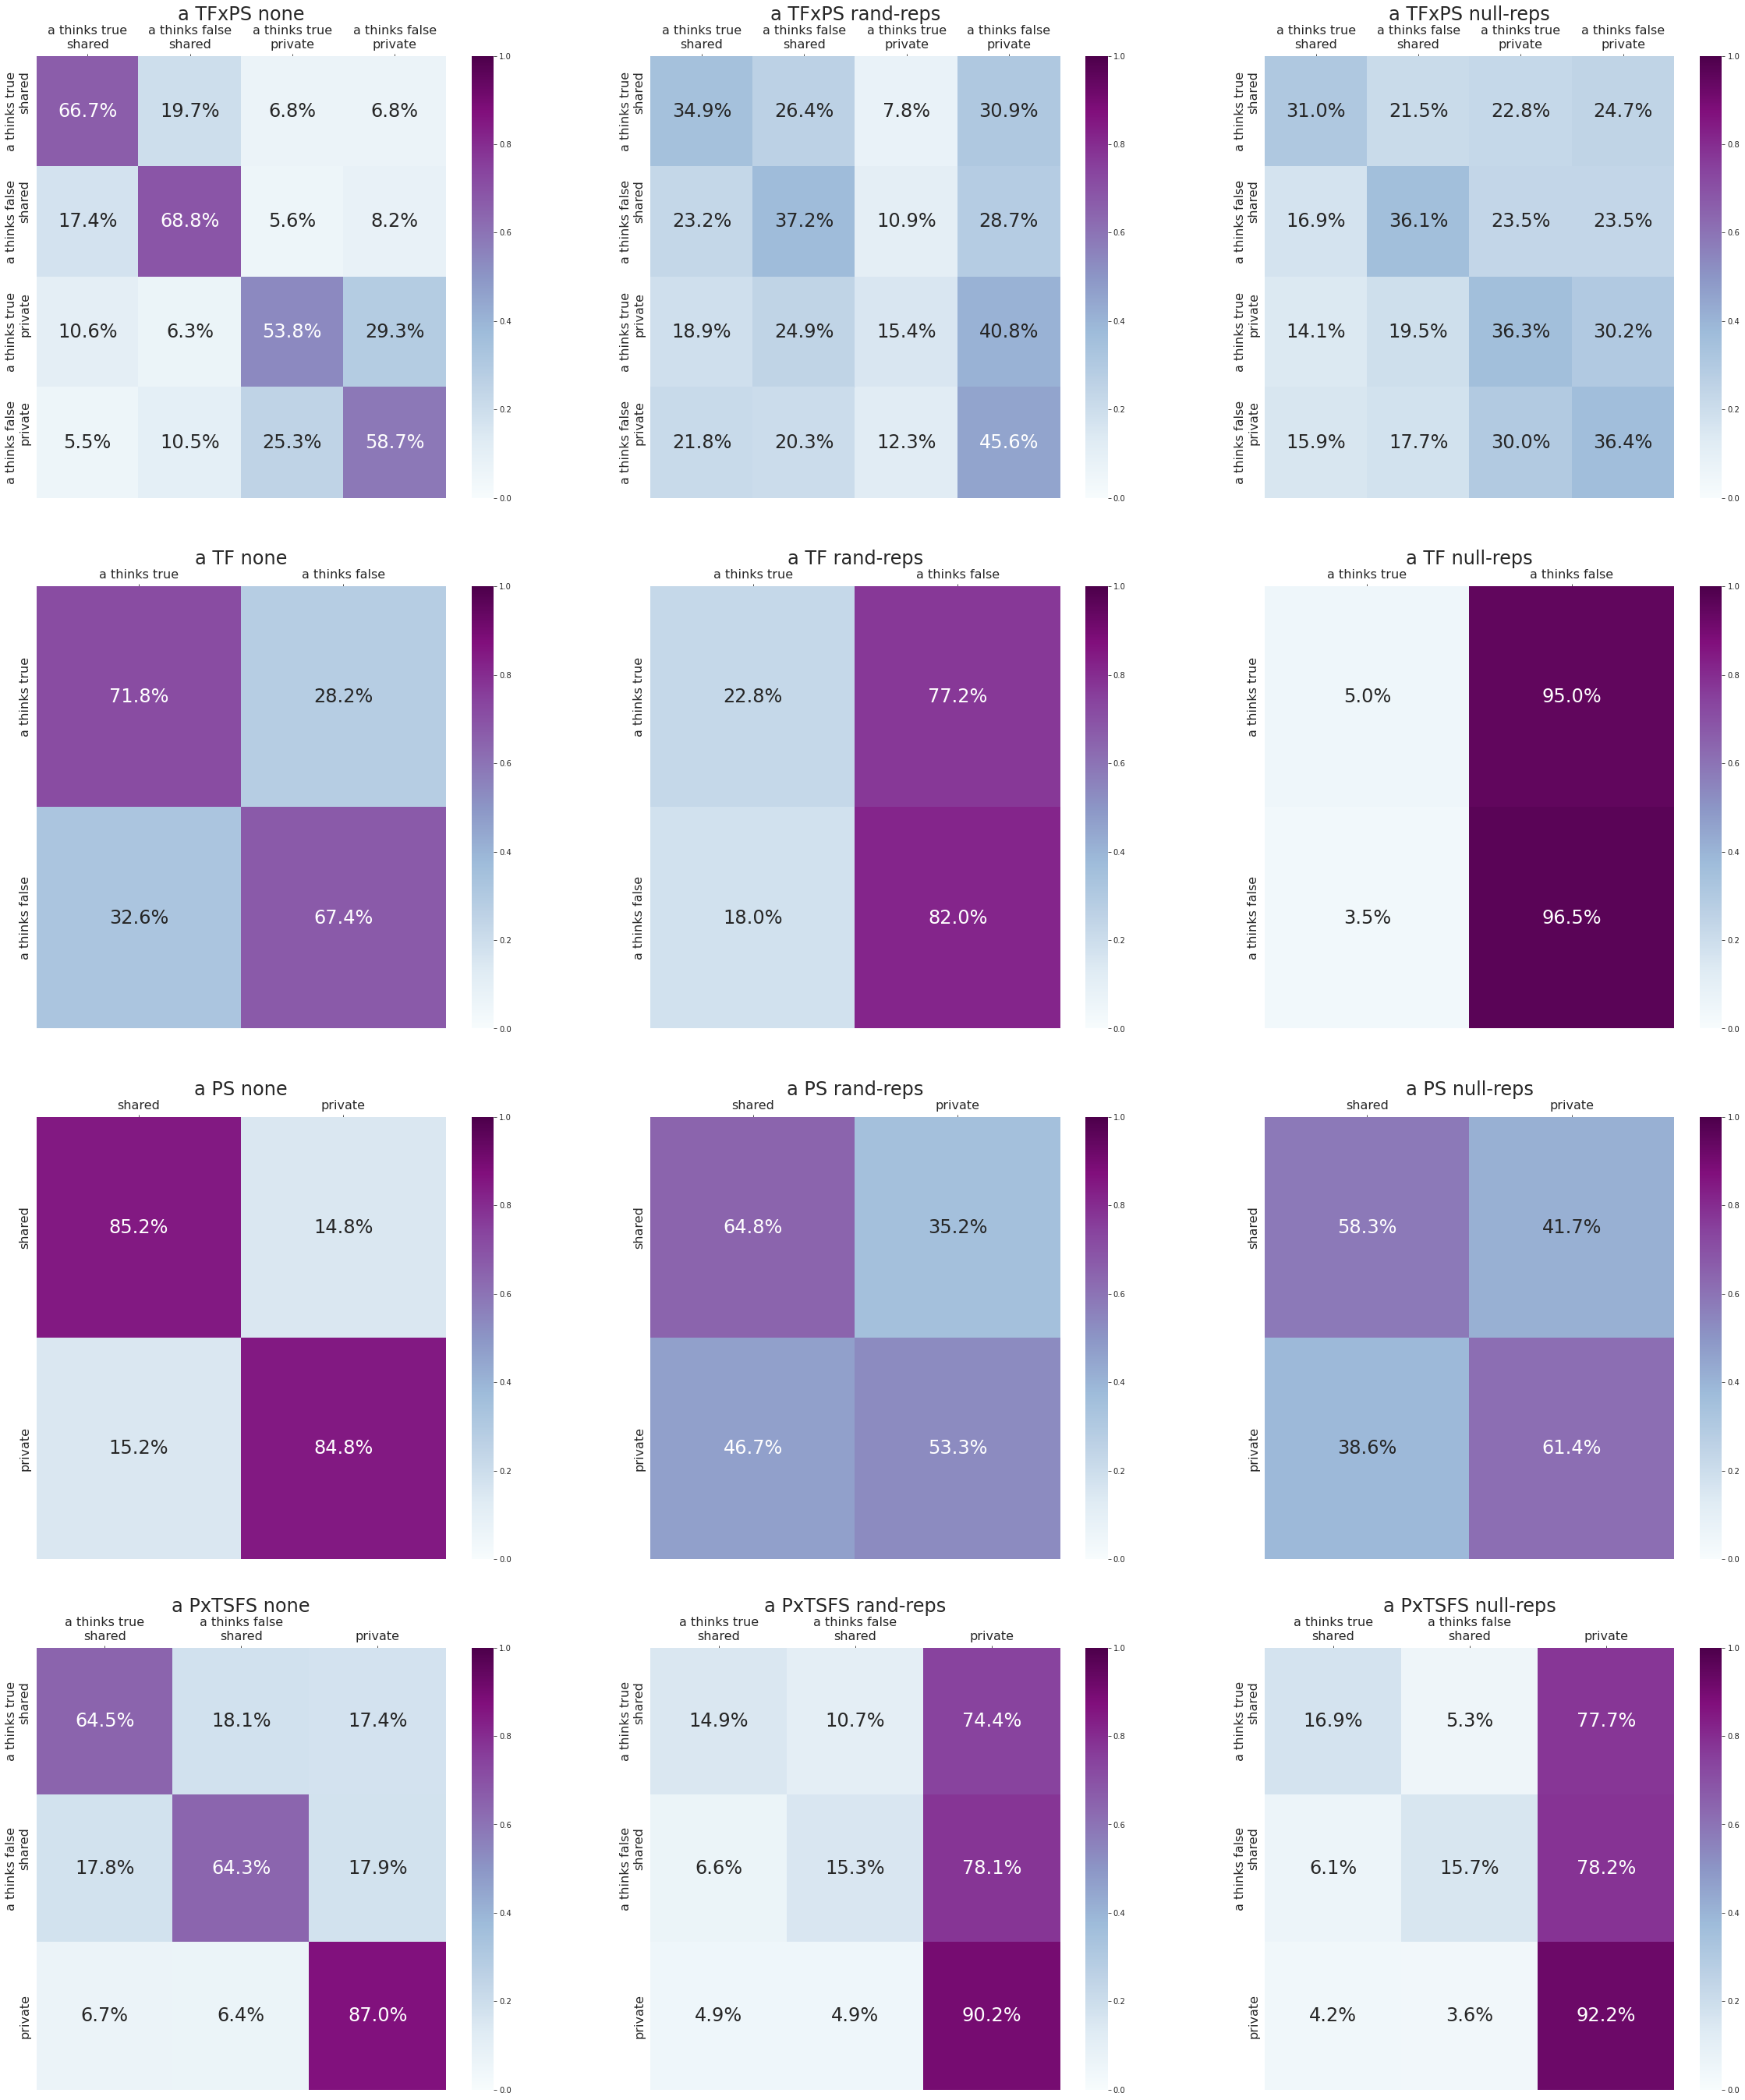

In [29]:
f, axes = plt.subplots(4, 3, figsize=(40, 48))
custom_palette = sns.color_palette("BuPu", as_cmap=True)

for t, task in enumerate(('TFxPS', 'TF', 'PS', 'PxTSFS')):
    for c, control in enumerate(('none', 'rand-reps', 'null-reps')): 
        ax = axes[t][c]

        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        cm = conf_matrices[(task, control)]
        sns.heatmap(cm, annot=True, fmt = '.1%', vmin=0, vmax=1, cmap=custom_palette, annot_kws={"fontsize":24}, ax=ax)
        ax.set_yticklabels(labels=ax.get_yticklabels(), va='center', rotation=90, fontsize=16)
        ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16)
        ax.set_title(f'{BOT} {task} {control}', fontsize=24)

#plt.savefig('assets_for_paper/confusion-matrix.pdf', bbox_inches='tight')
plt.show()

## Structured analysis

(dialogue state, probe, class) datapoints are not isolated, they are part of a more complex structure that we can represent with a matrix (the scoreboard).

#### From this point on, we'll look only into the main task (TFxPS) results

In [30]:
TASK = 'TFxPS'
CONTROL = 'none'

In [31]:
ID = 100  # pick an index between 0 and 2059 

d_outputs = next(d for d in dialogues[(TASK, CONTROL)].values() if d.dialogue_id == ID)
caption, turns = ev.get_vd_dialogue(ID, visdial[split])
props = [(i, p['proposition']) for i, p in props_data[split][str(ID)].items()]

types = [caption, *turns]
matrix = [[labels[TASK][c] for c in d_outputs.gold_scoreboard[j]] for j in range(d_outputs.gold_scoreboard.shape[0])] 
df_gold = pd.DataFrame(data=matrix, columns=types, index=[p.sentence for p in d_outputs.propositions])

The dialogue matrix's rows are the dialogue turns and its columns are the probes. Each cell (i, j) has the corresponding class of probe j at turn i, as in this example:

In [32]:
df_gold.transpose()

,the image is in color.,the image is not in color.,the image is outdoors.,the image is not outdoors.,it is sunny.,it is not sunny.,one cannot see any trees.,one can see trees.,one can see grass.,one cannot see any grass.,the 2 zebras are white and black.,the 2 zebras are not white and black.,the field is grassy.,the field is not grassy.
2 zebras jump towards each other in a field.,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
"is this photo in color? yes, it is.",a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
is this outdoors? yes.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
is it sunny? yes.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
can you see any trees? no trees.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
can you see grass? yes.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
how many zebras are there? 2.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private,a_thinks_true and private,a_thinks_false and private
what color are they? black and white.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private
can you see any dirt? a little bit.,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private
"is this in a zoo? no, it's in the wild.",a_thinks_true and shared,a_thinks_false and shared,a_thinks

### Analysing outcomes on probe level (columns in the dialogue matrix)

So now we move on to the first level of structure we have: each probe was paired with eleven turns that form the dialogue sequence, i.e., the columns in the matrix above.

What we can check in terms of probes:

   - accuracy (acc per column on matrix above)
   - accuracy wrt T/F only
   - accuracy wrt P/S only
   - does it shift from private to shared at the right turn?
   - does it shift from private to shared ONLY at the right turn?
   - how many shifts in the private/shared dimension occur? should be 0 for caption probes and 1 for other probes, never more than that.
   - is it stable wrt the true/false dimension?
   - how many shifts in the true/false dimension? any shift in T/F is wrong, but a shift from a wrong class to a correct class is better than a shift from a correct class to a wrong class.
   - how many shifts (of any kind) occured? there should be only one, from p to s
   - how many class types were assigned to this probe in this dialogue? should be 1 for captions and 2 for other probes, never more than that.
    

For the questioner, we can not completely disentangle T/F from 'don't know'. They belong to the same dimension. We can check whether is does not mix up true with false once the probe becomes shared, but estimating accuracy only wrt T/F would require adaption to take into account varying lengths for each probe.

   - there must be a shift from don't know to another class, or no shifts for captions
   
Here, all analysis can be done also by separating probes per type:
- $A$ thinks true for or $A$ thinks false
- positive, negative, neutral fact
- which turn from 0 to 10 it derives from
- which type of manipulation rule was used to create the probe

In [33]:
df = pd.DataFrame(columns= ['acc', 'T/F acc', 'P/S acc', 'p2s at right turn', 
                            'p2s only at right turn', '% is t/f stable', 'labels per probe',
                            'shifts per probe', 't/f shifts per probe', 'p/s shifts per probe'])

# building ideal values for each metric below

overall_acc = 100
TF_acc = 100 if BOT == 'a' else 'N/A'
PS_acc = 100
P2S_right_turn = 100
P2S_only_right_turn = 100
is_TF_stable = 100
labels_per_probe = np.mean([len(set(prop.gold)) for prop in probes[(TASK, CONTROL)].values()])
shifts_per_probe = np.mean([len([list(j) for i, j in groupby(prop.gold)]) - 1 for prop in probes[(TASK, CONTROL)].values()])

tf_shifts = []
ps_shifts = []
for probe in probes[(TASK, CONTROL)].values():
    tf_preds = np.isin(probe.gold, probe.true_labels).astype(int)
    tf_shifts.append(len([list(j) for i, j in groupby(tf_preds)]) - 1)
    
    ps_preds = np.isin(probe.gold, probe.shared_labels).astype(int)
    ps_shifts.append(len([list(j) for i, j in groupby(ps_preds)]) - 1)

TF_shifts = np.mean(tf_shifts) if TASK != 'PS' else 'N/A'
PS_shifts = np.mean(ps_shifts) if TASK != 'TF' else 'N/A'

gold_metrics = [overall_acc, TF_acc, PS_acc, P2S_right_turn, P2S_only_right_turn, is_TF_stable,
                 labels_per_probe, shifts_per_probe, TF_shifts, PS_shifts]

df.loc['ideal'] = gold_metrics

for control in CONTROL_TASKS:
    title = f'{BOT} {TASK} {control}'
    propositions = probes[(TASK, control)].values()  

    overall_acc = 100 * np.mean([probe.acc for probe in propositions])
    TF_acc = 100 * np.mean([probe.tf_acc for probe in propositions]) if TASK != 'PS' else 'N/A'
    PS_acc = 100 * np.mean([probe.ps_acc for probe in propositions])
    P2S_right_turn = 100 * np.mean([probe.right_turn_ps_shift for probe in propositions])
    P2S_only_right_turn = 100 * np.mean([probe.only_right_turn_ps_shift for probe in propositions])
    is_TF_stable = 100 * np.mean([probe.is_tf_stable for probe in propositions])
    labels_per_probe = np.mean([probe.n_labels for probe in propositions])
    shifts_per_probe = np.mean([probe.n_shifts for probe in propositions])
    TF_shifts = np.mean([probe.n_tf_shifts for probe in propositions]) if TASK != 'PS' else 'N/A'
    PS_shifts = np.mean([probe.n_ps_shifts for probe in propositions])
    
    metrics = [overall_acc, TF_acc, PS_acc, P2S_right_turn, P2S_only_right_turn, is_TF_stable,
               labels_per_probe, shifts_per_probe, TF_shifts, PS_shifts]
    df.loc[title] = metrics
    
pd.set_option('precision', 4)
df.transpose()

,ideal,a TFxPS none,a TFxPS rand-reps,a TFxPS null-reps
acc,100.0000,62.4612,33.5216,34.8463
T/F acc,100.0000,71.3542,52.3788,54.6432
P/S acc,100.0000,85.0233,59.1154,59.0270
p2s at right turn,100.0000,60.3296,16.9037,6.9384
p2s only at right turn,100.0000,38.2437,3.1917,6.4701
% is t/f stable,100.0000,44.5013,24.8786,92.6193
labels per probe,1.9099,2.6187,2.2148,1.0779
shifts per probe,0.9099,2.7192,3.1175,0.2163
t/f shifts per probe,0.0000,1.5094,2.4727,0.2064
p/s shifts per probe,0.9099,1.6816,2.2065,0.0876


We can also analyse these numbers spliting by type of probe. In the dataframes below, we see the results of each type of probe sentence. The columns mean the turn from which a probe is derived.

In [34]:
metric = ev.get_acc # select a function on evaluationaux for which kind of metric to extract

In [35]:
TURNS = 11 # we can use it as a constant for the validation set

In [36]:
dfs = []

for control in CONTROL_TASKS:
    title = f'{BOT} {TASK} {control}'
    propositions = probes[(TASK, control)]

    df = pd.DataFrame(columns=[i for i in range(11)])

    split_per_turn = {i: {idxs: prop for idxs, prop in propositions.items() if prop.turn_shared == i} for i in range(TURNS)}
    df.loc['overall'] = pd.Series({i: metric(split_per_turn[i]) for i in range(TURNS)})

    for cat in ['positive', 'negative', 'neutral']:
        split_per_turn = {i: {idxs: prop for idxs, prop in propositions.items() if prop.polarity == cat and prop.turn_shared == i} for i in range(TURNS)}
        c = cat if cat != 'neutral' else 'not polar q'
            
        df.loc[c] = pd.Series({i: metric(split_per_turn[i]) for i in range(TURNS)})

    for cat in [1, 0]:
        split_per_turn = {i: {idxs: prop for idxs, prop in propositions.items() if prop.a_thinks_true == cat and prop.turn_shared == i} for i in range(TURNS)}
        cat = 'entailment' if cat == 1 else 'contradiction'
        df.loc[cat] = pd.Series({i: metric(split_per_turn[i]) for i in range(TURNS)})
    df.style.set_caption(title)  
    dfs.append(df)

for title, df in zip(['main task', 'rand-reps', 'null-reps'], dfs):
    print(title)
    display(df)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


main task


,0,1,2,3,4,5,6,7,8,9,10
overall,0.5619,0.7456,0.6585,0.6523,0.6568,0.6459,0.6586,0.6380,0.5895,0.5568,0.5105
positive,NaN,0.7952,0.6906,0.6465,0.6232,0.6217,0.6098,0.5905,0.5476,0.5006,0.4689
negative,NaN,0.7178,0.6386,0.6642,0.6945,0.6752,0.7090,0.6982,0.6387,0.6098,0.5668
not polar q,0.5619,0.6644,0.6440,0.6424,0.6425,0.6228,0.6198,0.5691,0.5330,0.5273,0.4299
entailment,0.5578,0.7384,0.6475,0.6319,0.6396,0.6223,0.6338,0.6211,0.5693,0.5332,0.4924
contradiction,0.5660,0.7528,0.6695,0.6726,0.6741,0.6695,0.6834,0.6549,0.6096,0.5803,0.5286


rand-reps


,0,1,2,3,4,5,6,7,8,9,10
overall,0.6387,0.4110,0.3113,0.2902,0.2758,0.2739,0.2741,0.2869,0.3036,0.3005,0.3180
positive,NaN,0.5597,0.4430,0.3705,0.3277,0.3121,0.2864,0.2720,0.2698,0.2554,0.2536
negative,NaN,0.1019,0.1246,0.1631,0.1824,0.2142,0.2481,0.2836,0.3325,0.3473,0.3845
not polar q,0.6387,0.4588,0.3982,0.3688,0.3538,0.3405,0.3145,0.3213,0.2880,0.2650,0.2527
entailment,0.6270,0.3331,0.2727,0.2556,0.2308,0.2176,0.1996,0.2006,0.1943,0.1644,0.1680
contradiction,0.6505,0.4889,0.3500,0.3248,0.3207,0.3302,0.3486,0.3732,0.4128,0.4365,0.4680


null-reps


,0,1,2,3,4,5,6,7,8,9,10
overall,0.7090,0.4563,0.2964,0.2476,0.2389,0.2498,0.2697,0.2907,0.3271,0.3463,0.3884
positive,NaN,0.6485,0.4063,0.2953,0.2503,0.2425,0.2177,0.2175,0.2368,0.2406,0.2703
negative,NaN,0.1277,0.1383,0.1764,0.2076,0.2608,0.3045,0.3562,0.4242,0.4638,0.5220
not polar q,0.7090,0.4264,0.3719,0.2881,0.2734,0.2379,0.2721,0.2534,0.2301,0.2424,0.2351
entailment,0.6878,0.4303,0.2745,0.2179,0.2222,0.2339,0.2588,0.2835,0.3211,0.3467,0.3846
contradiction,0.7302,0.4822,0.3183,0.2774,0.2557,0.2657,0.2806,0.2980,0.3331,0.3459,0.3922


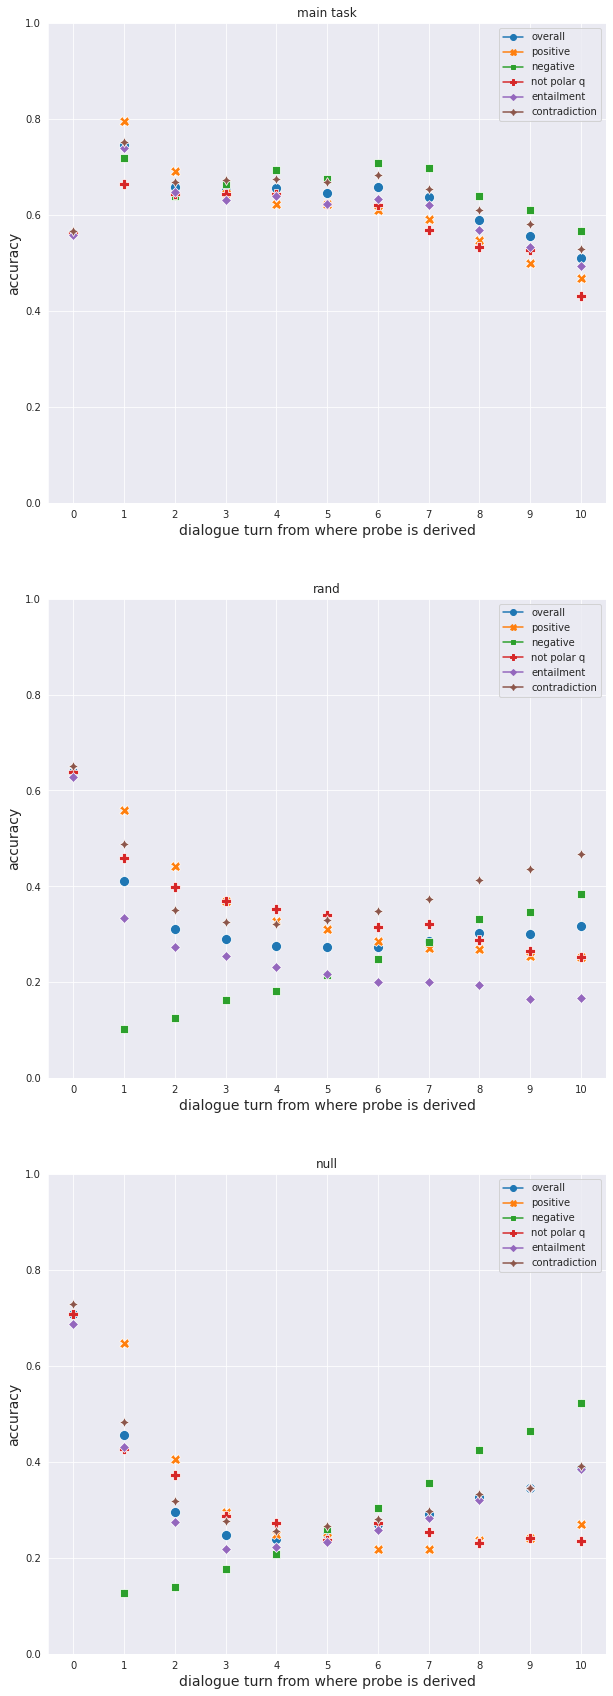

In [37]:
f, axes = plt.subplots(3, 1, figsize=(10, 30))

for ax, df, title in zip(axes.flatten(), dfs, ['main task', 'rand', 'null']):
    
    sns.set_style("darkgrid")
    sns.lineplot(data=df.transpose(), palette='tab10', dashes=False, linewidth = 0, 
                     markers=True, markersize=10, ax=ax)
    
    ax.set_ylim(0., 1)
    ax.set_ylabel('accuracy', fontsize=14)
    ax.set_xlabel('dialogue turn from where probe is derived', fontsize=14)
    ax.set_xticks(list(range(11)))
    ax.set_title(title)
    
#plt.savefig('assets_for_paper/acc-prop-details_'+BOT+'.pdf')
plt.show()

Saving one for the paper:

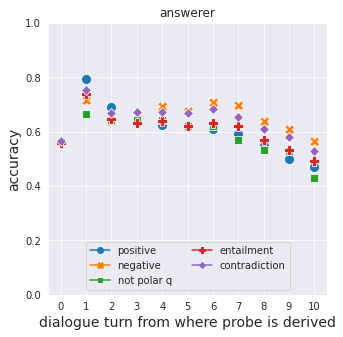

In [38]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

df = dfs[0] 
#df = df.drop('true')
#df = df.drop('false')
df = df.drop('overall')
title = 'answerer'
ax = axes    
sns.set_style("darkgrid")
sns.lineplot(data=df.transpose(), palette='tab10', dashes=False, linewidth = 0, 
                 markers=True, markersize=10, ax=ax)

ax.set_ylim(0., 1)
ax.set_ylabel('accuracy', fontsize=14)
ax.set_xlabel('dialogue turn from where probe is derived', fontsize=14)
ax.set_xticks(list(range(11)))
ax.set_title(title)

plt.legend(ncol=2, loc='lower center')

plt.savefig('assets_for_paper/acc-prop-details_'+BOT+'.pdf')
plt.show()

### Analysing outcomes on dialogue turn level (rows in the dialogue matrix)

- accuracy (per row)
- T/F accuracy (per row)
- P/S accuracy (per row)
- each turn should cause changes from private to shared only on its respective probes
- turns should not cause shifts in the true/false dimension, but a shift that corrects a previously wrong class is better than a shifts that makes it wrong
- accuracy of shifts per turn?

Let's see how the three accuracies evolve throughout turns.

In [39]:
pred_at_t5 = {}
gold_at_t5 = {}

df_at_t5 = pd.DataFrame(columns=['overall acc at turn 5'])

for task, control in product(TASKS, CONTROL_TASKS): 
    pred = [p.predictions[5] for p in probes[(task, control)].values()]
    gold = [p.gold[5] for p in probes[(task, control)].values()]

    pred_at_t5[(task, control)] = pred
    gold_at_t5[(task, control)] = gold 
    df_at_t5.loc[f'{task} {control}'] = np.mean(np.array([pred]) == np.array([gold]))
        
df_at_t5*100

,overall acc at turn 5
TFxPS none,57.9792
TFxPS rand-reps,33.4822
TFxPS null-reps,37.4415
TF none,70.3209
TF rand-reps,52.4545
TF null-reps,50.7502
PS none,76.3140
PS rand-reps,62.0902
PS null-reps,63.9462
PxTSFS none,68.1310


In [40]:
conf_matrices_at_t5 = {}
dfs_at_t5 = {}

for task, control in product(TASKS, CONTROL_TASKS): 
    pred = pred_at_t5[(task, control)]
    gold = gold_at_t5[(task, control)]
    n_labels = len(labels[task])
    cm = confusion_matrix(gold, pred, labels = list(range(n_labels)))
    cm = normalize(cm, axis=1, norm='l1')
    classes =[labels[task][i].replace('_', ' ').replace(' and ', '\n') for i in range(n_labels)]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)

    conf_matrices_at_t5[(task, control)] = cm
    dfs_at_t5[(task, control)] = df_cm

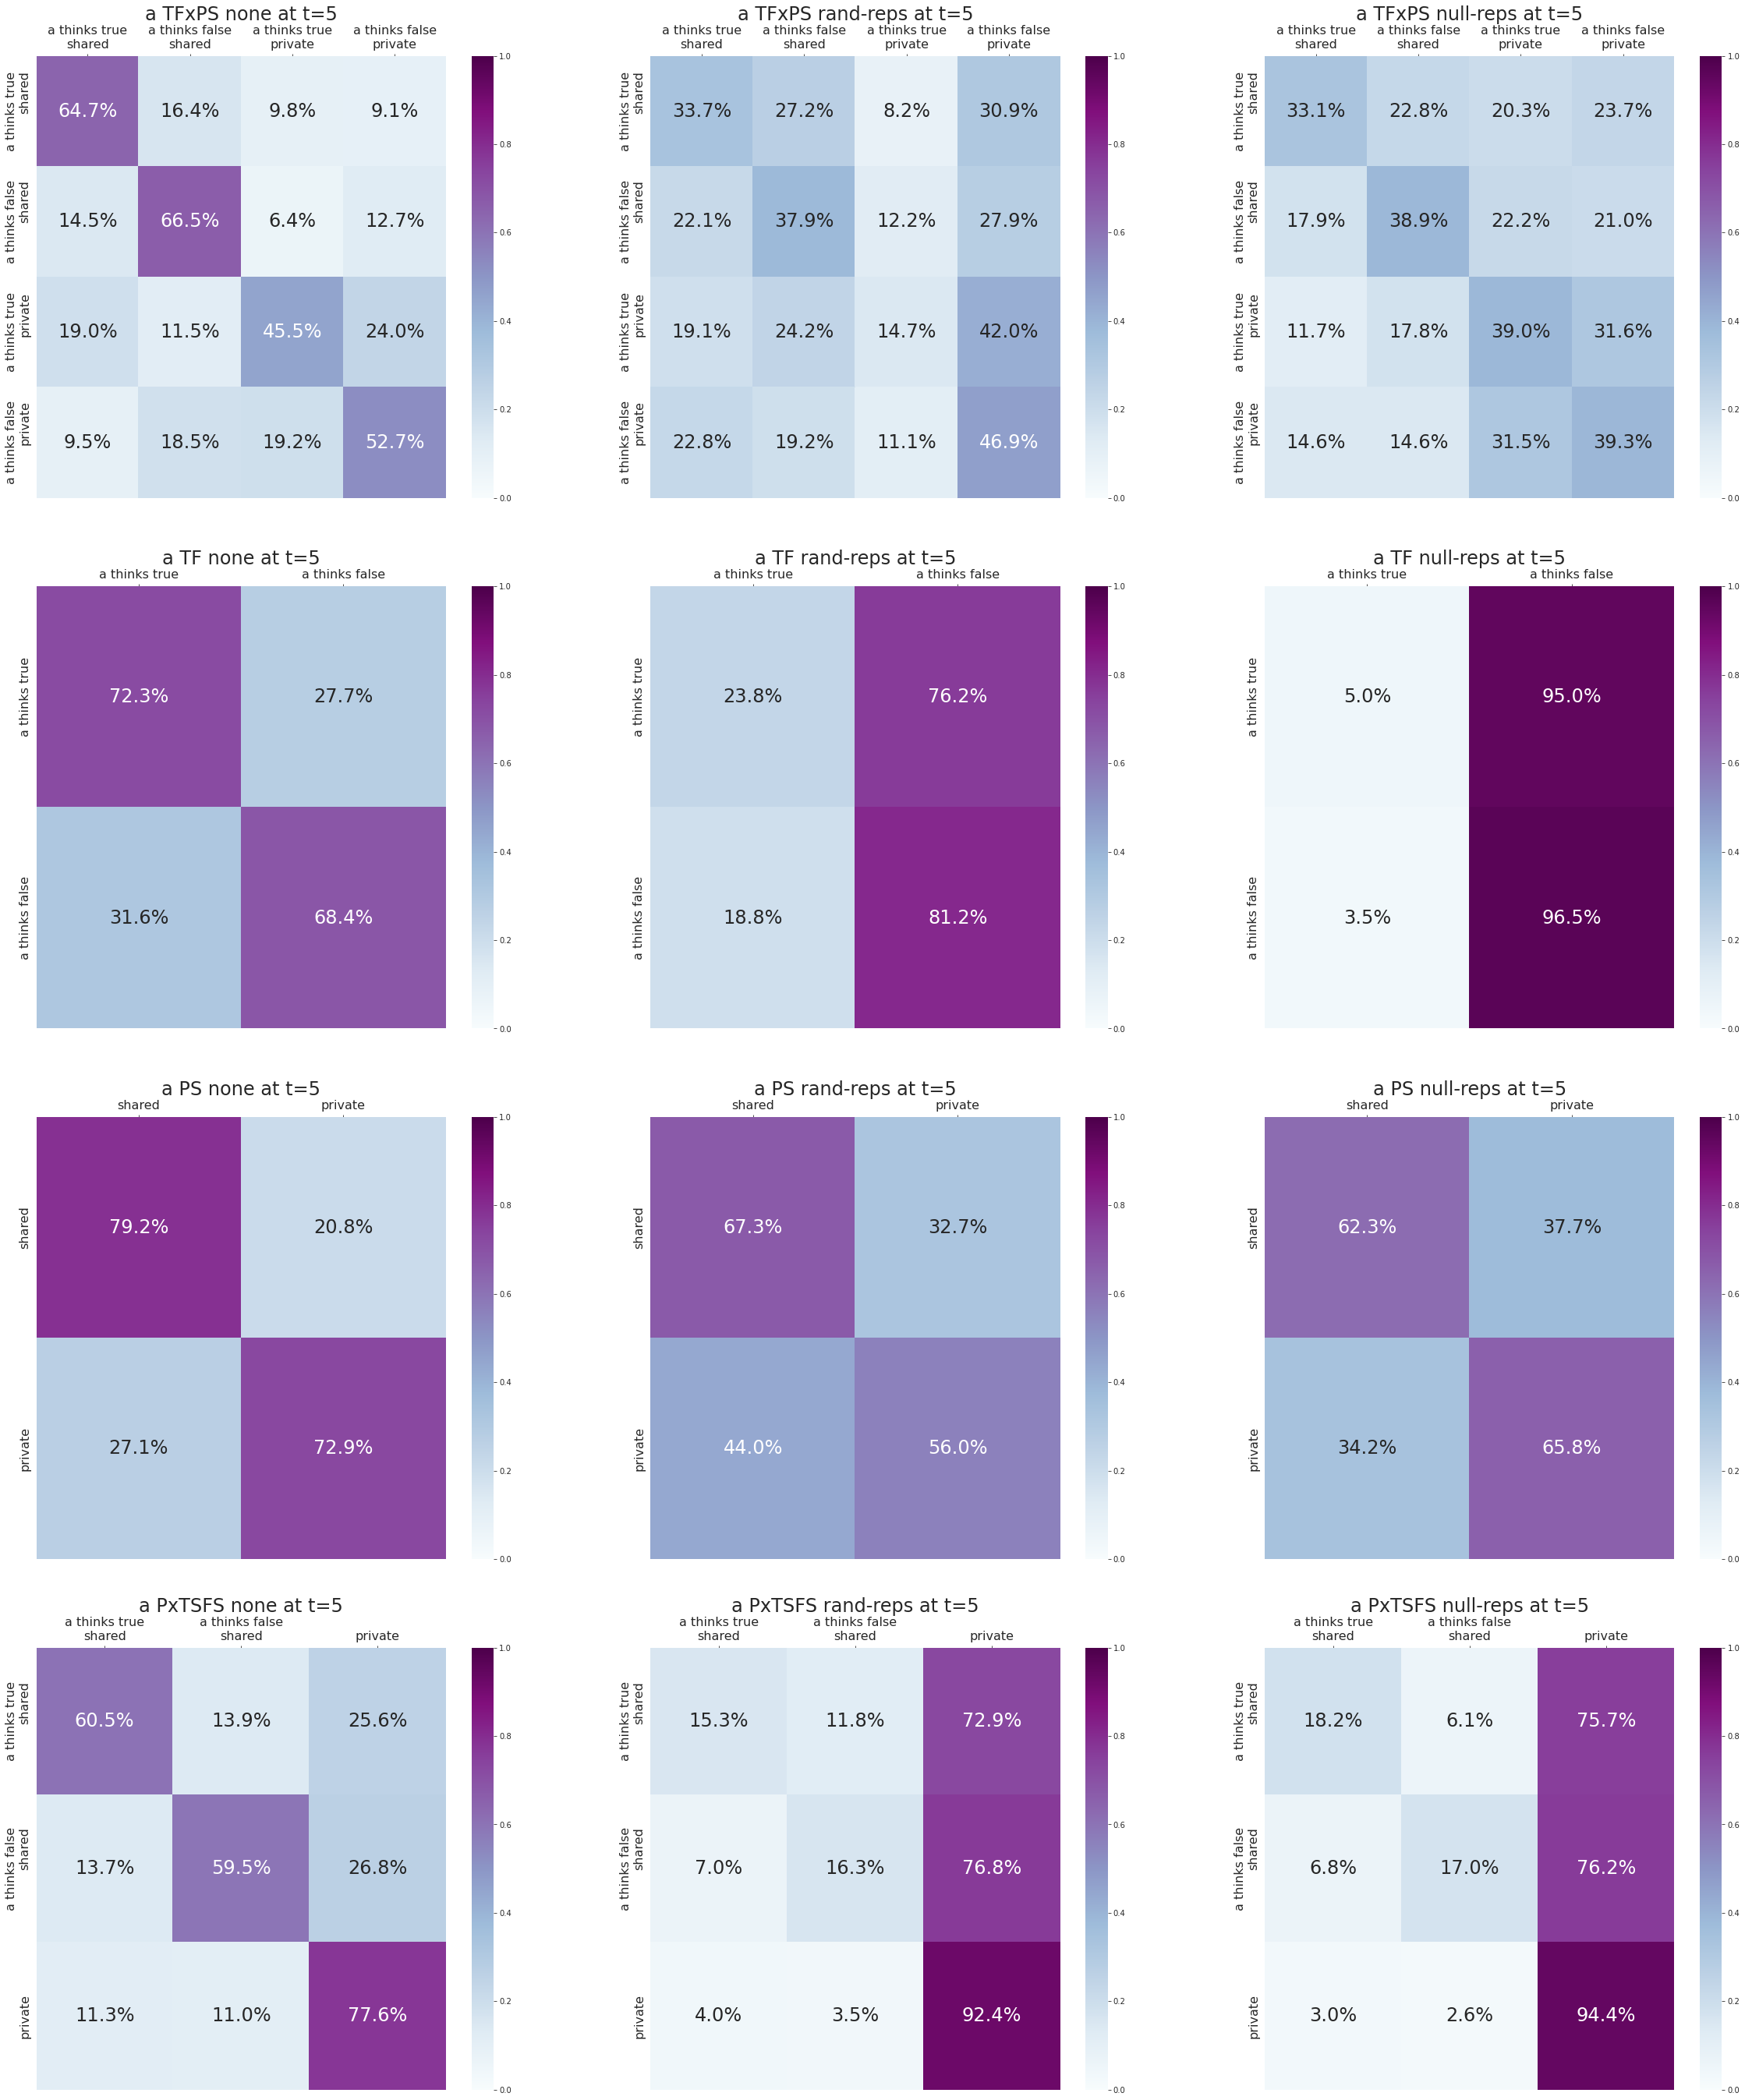

In [41]:
f, axes = plt.subplots(4, 3, figsize=(40, 48))
custom_palette = sns.color_palette("BuPu", as_cmap=True)

for t, task in enumerate(('TFxPS', 'TF', 'PS', 'PxTSFS')):
    for c, control in enumerate(('none', 'rand-reps', 'null-reps')): 
        ax = axes[t][c]
        
        df_cm = dfs_at_t5[(task, control)]

        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        sns.heatmap(df_cm, annot=True, fmt = '.1%', vmin=0, vmax=1, cmap=custom_palette, annot_kws={"fontsize":24}, ax=ax)
        ax.set_yticklabels(labels=ax.get_yticklabels(), va='center', rotation=90, fontsize=16)
        ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16)
        ax.set_title(f'{BOT} {task} {control} at t=5', fontsize=24)


#plt.savefig('assets_for_paper/confusion-matrix.pdf', bbox_inches='tight')
plt.show()

One example for the paper:

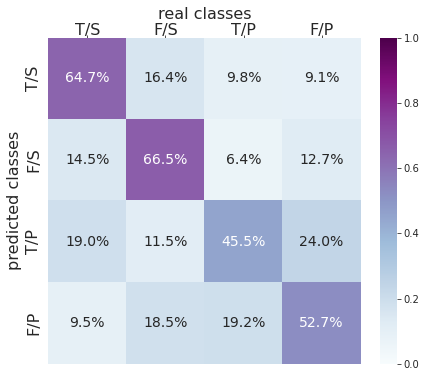

In [42]:
abbreviation = {'a_thinks_true and shared': 'T/S', 
                'a_thinks_true and private': 'T/P', 
                'a_thinks_false and shared': 'F/S', 
                'a_thinks_false and private': 'F/P' }

cm = conf_matrices_at_t5[(TASK, 'none')]
classes = labels[TASK]
n_labels = len(classes)

df_cm = pd.DataFrame(cm, index=[abbreviation[classes[i]] for i in range(n_labels)], 
                           columns=[abbreviation[classes[i]] for i in range(n_labels)])

f, ax = plt.subplots(1, 1, figsize=(7, 6))
custom_palette = sns.color_palette("BuPu", as_cmap=True)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(df_cm, annot=True, fmt = '.1%', vmin=0, vmax=1, cmap=custom_palette, annot_kws={"fontsize":14}, ax=ax)
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center', rotation=90, fontsize=16)
ax.set_xticklabels(labels=ax.get_xticklabels(), va='center', rotation=0, fontsize=16)

ax.set_xlabel('real classes', fontsize=16)
ax.set_ylabel('predicted classes', fontsize=16)

#plt.savefig('assets_for_paper/cmatrix_aBot_turn5.pdf')
plt.show()

Making it smaller:

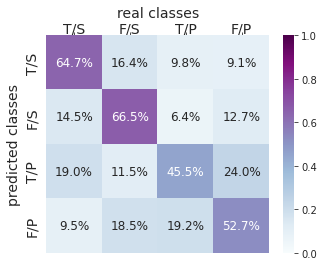

In [43]:
abbreviation = {'a_thinks_true and shared': 'T/S', 
                'a_thinks_true and private': 'T/P', 
                'a_thinks_false and shared': 'F/S', 
                'a_thinks_false and private': 'F/P' }

df_cm = pd.DataFrame(cm, index=[abbreviation[classes[i]] for i in range(n_labels)], 
                           columns=[abbreviation[classes[i]] for i in range(n_labels)])

f, ax = plt.subplots(1, 1, figsize=(5, 4))
custom_palette = sns.color_palette("BuPu", as_cmap=True)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(df_cm, annot=True, fmt = '.1%', vmin=0, vmax=1, cmap=custom_palette, annot_kws={"fontsize":12}, ax=ax)
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center', rotation=90, fontsize=14)
ax.set_xticklabels(labels=ax.get_xticklabels(), va='center', rotation=0, fontsize=14)

ax.set_xlabel('real classes', fontsize=14)
ax.set_ylabel('predicted classes', fontsize=14)

plt.savefig('assets_for_paper/cmatrix_aBot_turn5.pdf')
plt.show()

In [44]:
inc_acc = {}

for task, control in product(TASKS, CONTROL_TASKS):  
    inc_acc[(task, control)] = ev.acc_per_turn(dialogues[(task, control)])

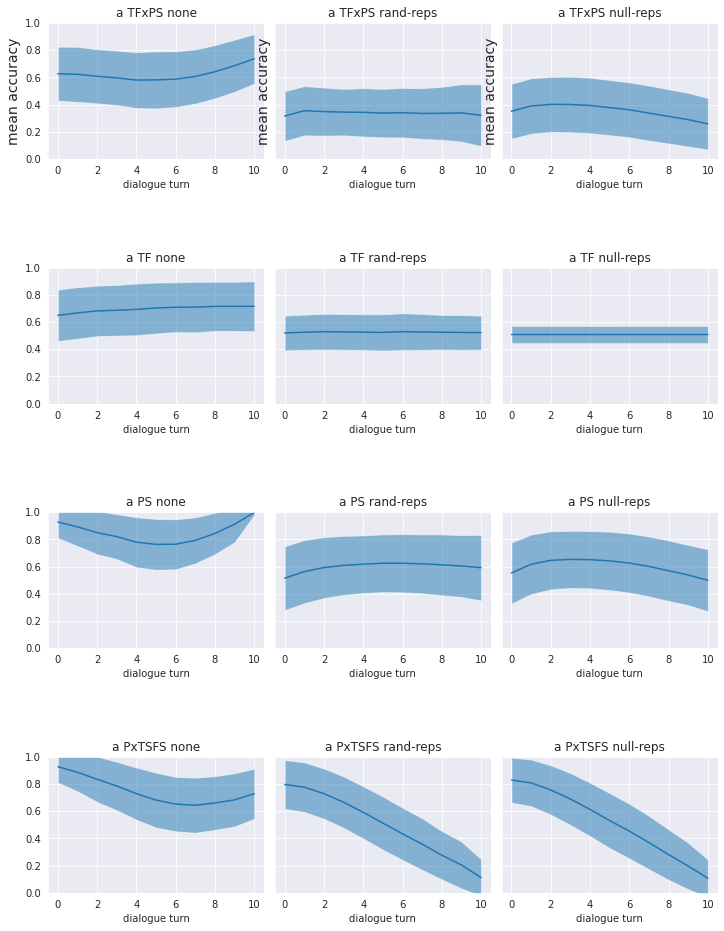

In [45]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.8)

for t, task in enumerate(('TFxPS', 'TF', 'PS', 'PxTSFS')):
    for c, control in enumerate(('none', 'rand-reps', 'null-reps')):
        ax = axes[t][c]
        title = f'{BOT} {task} {control}'
        t_accs, t_std, *_= inc_acc[(task, control)]
        ax.plot(t_accs, '-')
        ax.fill_between(range(11), t_accs-t_std, t_accs+t_std, alpha = 0.5)
        if t == 0:
            ax.set_ylabel('mean accuracy', fontsize=14)
        ax.set_xlabel('dialogue turn')
        ax.set_title(title)
        ax.set_ylim(0, 1)

    
#plt.savefig('assets_for_paper/acc-dialogue-turn_'+BOT+'.pdf')
plt.show()

For the paper, only the main task:

TFxPS [0.62732121 0.62253581 0.60820691 0.59661301 0.58039541 0.58161351
 0.58710402 0.6069042  0.64181371 0.68637481 0.73718282]
TF [0.6492259  0.66685732 0.68173639 0.68641557 0.69313612 0.70317155
 0.70892765 0.70973531 0.71546552 0.71542493 0.71570728]
PS [0.92831508 0.89242244 0.85038245 0.82087821 0.77960359 0.76387637
 0.76481434 0.79321343 0.84454466 0.91201635 0.99851607]
PxTSFS [0.92824339 0.88662946 0.83519141 0.78594252 0.72944832 0.68215662
 0.6526522  0.64434438 0.66107693 0.68385117 0.72947789]


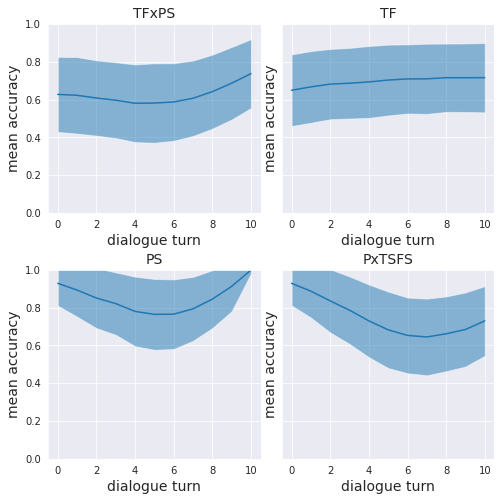

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

acc_std_list = [inc_acc[(task, 'none')] for task in TASKS]

for l, ax in enumerate(axes.flatten()):

    t_accs, t_std, *_= acc_std_list[l]
    print(TASKS[l], t_accs)
    ax.plot(t_accs, '-')
    ax.fill_between(range(11), t_accs-t_std, t_accs+t_std, alpha = 0.5)
    ax.set_ylabel('mean accuracy', fontsize=14)
    ax.set_xlabel('dialogue turn', fontsize=14)
    ax.set_title(TASKS[l], fontsize=14)
    ax.set_ylim(0, 1)

        
plt.savefig('assets_for_paper/acc-dialogue-turn_'+BOT+'.pdf')
plt.show()

### Analysing outcomes on full dialogues

- accuracy (over whole matrix)
- T/F accuracy 
- P/S accuracy
- precision, recall and F1 of P/S shifts: a dialogue matrix with n probes should have up to n (sometimes less when it has caption probes) shifts from private to shared and they should happen on the correct corresponding turns, so we can estimate:
    - precision: correct p->s shifts / all p->s + s->p shifts in the predictions
    - recall: correct p->s shifts / gold p->s shifts
    - predictions that are more unstable (too many unnecessary shifts) should have a low precision
    - predictions that are less unstable but shifts at wrong turns should have a low recall
    - we need to define precision, recall for caption probes: predicting no shift means p=r=1, predicting any shift means p=r=0.
- proportion of stable probes wrt T/F
- proportion of stable AND correct probes wrt T/F

In [47]:
df = pd.DataFrame(columns=['acc', 'T/F acc', 'P/S acc', '% is t/f stable'])

for control in CONTROL_TASKS:
    dials = dialogues[(TASK, control)].values()   
    metrics = []
    metrics.append(np.mean([d.acc for d in dials]))
    metrics.append(np.mean([d.tf_acc for d in dials]))
    metrics.append(np.mean([d.ps_acc for d in dials]))
    metrics.append(np.mean([d.tf_stability for d in dials]))
    
    df.loc[control] = metrics
    
df.transpose() * 100

,none,rand-reps,null-reps
acc,62.5097,33.7713,35.2200
T/F acc,71.3329,52.5895,54.8342
P/S acc,85.0450,59.2370,59.3502
% is t/f stable,44.5199,24.8870,92.4533


Histograms of accuracy per dialogue:

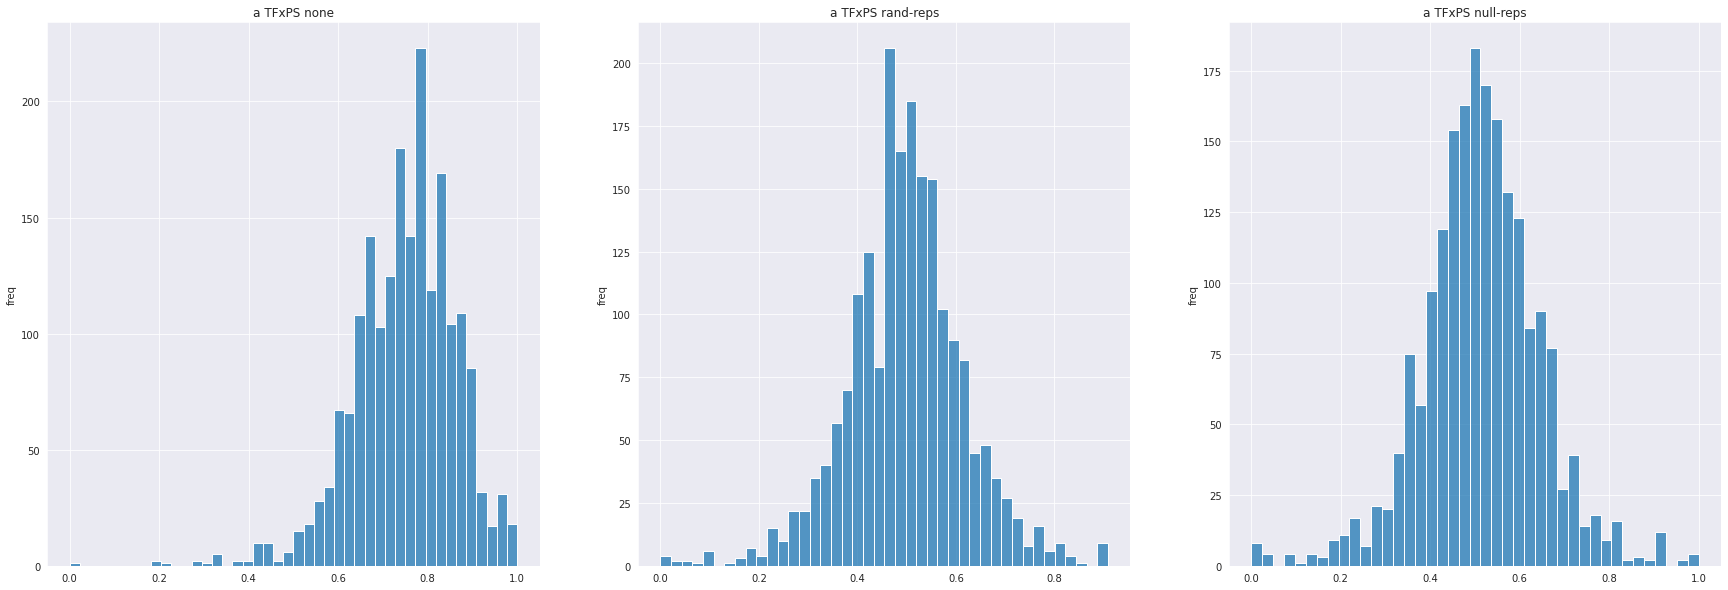

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for c, control in enumerate(CONTROL_TASKS):
    ax = axes[c]
    title = f'{BOT} {TASK} {control}'
    dials = dialogues[(task, control)]
                         
    accs = [d.acc for d in dials.values()]
    sns.histplot(accs, ax=ax)
    ax.set_ylabel('freq')
    ax.set_label('accuracy per dialogue')
    ax.set_title(title)
    
plt.show()

Histograms of P/S accuracy:

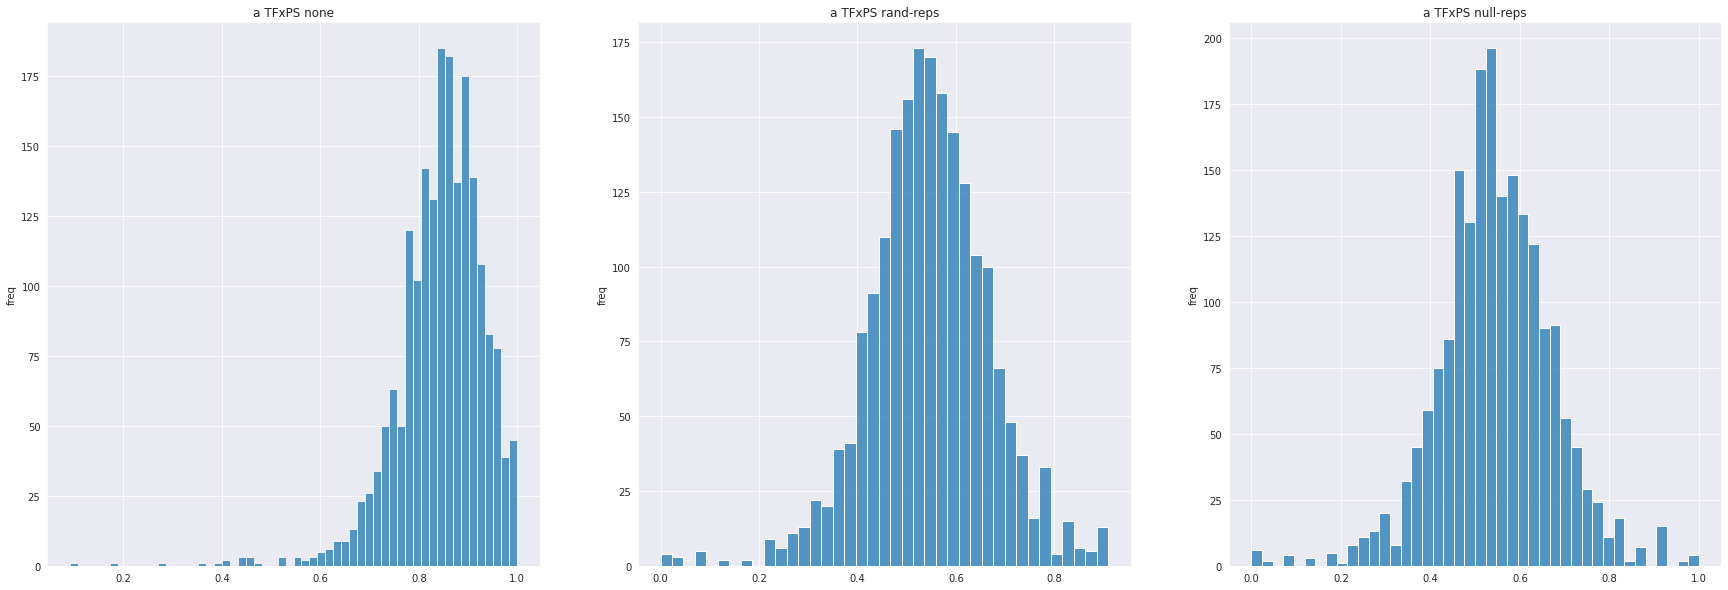

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for c, control in enumerate(CONTROL_TASKS):
    ax = axes[c]
    title = f'{BOT} {TASK} {control}'
    dials = dialogues[(task, control)]
                         
    accs = [d.ps_acc for d in dials.values()]
    sns.histplot(accs, ax=ax)
    ax.set_ylabel('freq')
    ax.set_label('accuracy per dialogue')
    ax.set_title(title)
    
plt.show()

Histograms of T/F accuracy:

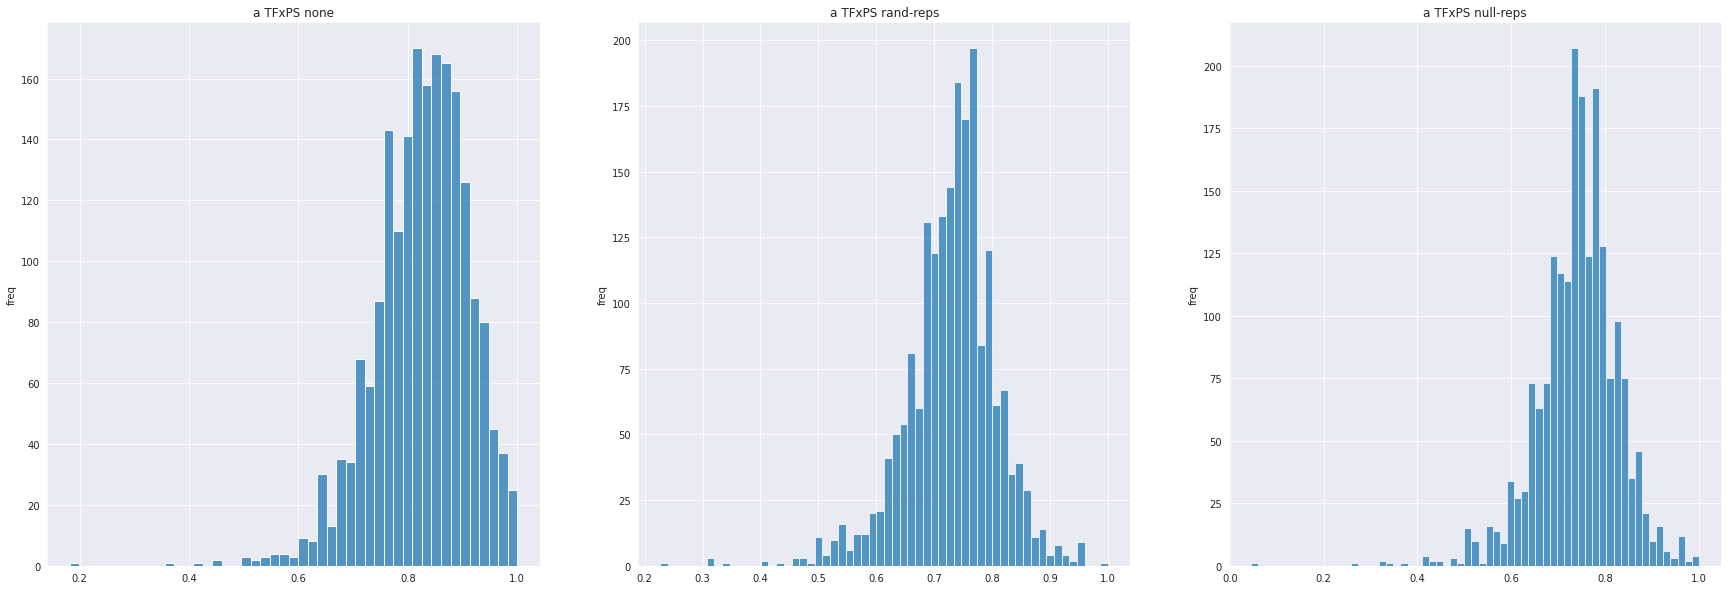

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for c, control in enumerate(CONTROL_TASKS):
    ax = axes[c]
    title = f'{BOT} {TASK} {control}'
    dials = dialogues[(task, control)]
                         
    accs = [d.tf_acc for d in dials.values()]
    sns.histplot(accs, ax=ax)
    ax.set_ylabel('freq')
    ax.set_label('accuracy per dialogue')
    ax.set_title(title)
    
plt.show()

## Examining concrete examples

Pick a dialogue ID:

In [51]:
ID = 141  # pick an index between 0 and 2059 

Observing predicted scoreboards for this dialogue and comparing with gold ones:

/home/users/blasota/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


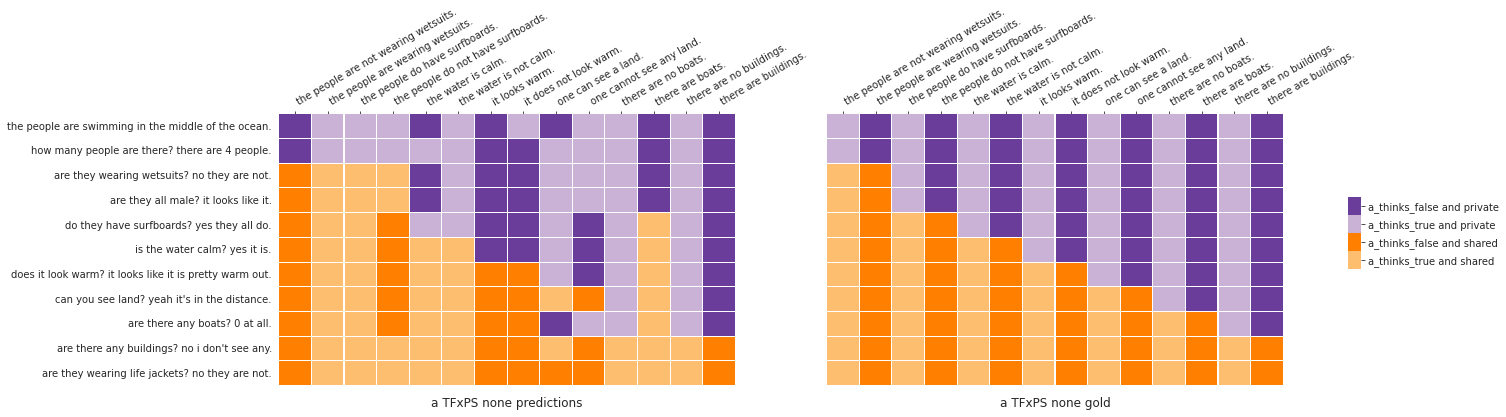

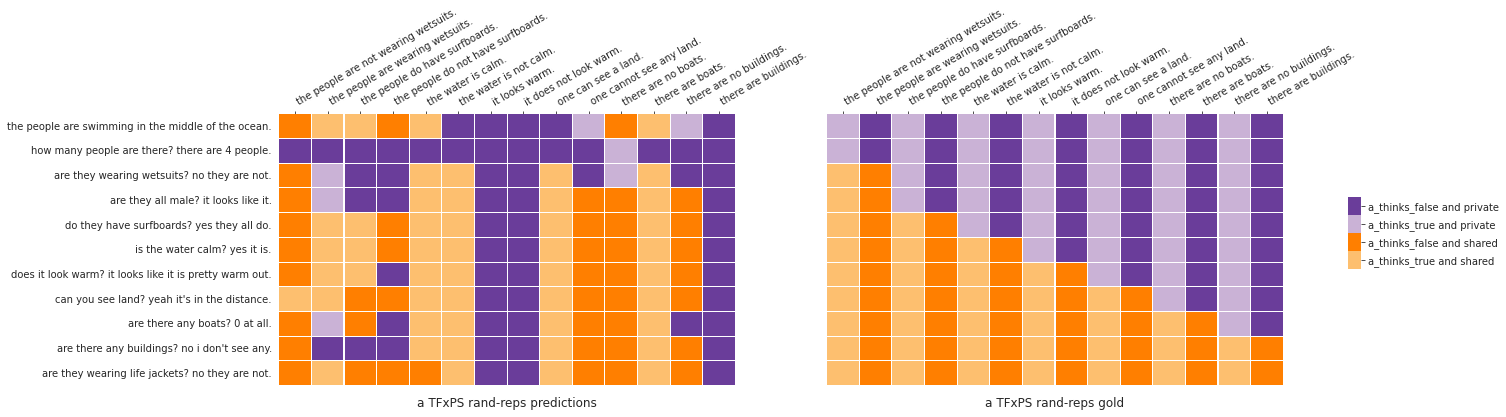

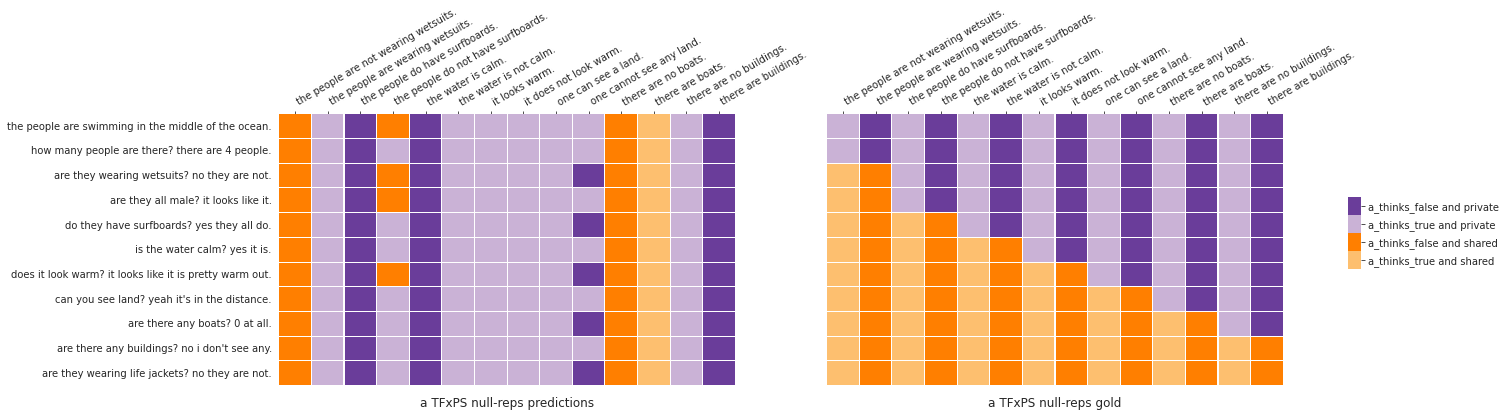

In [52]:
task = 'TFxPS'

for control in CONTROL_TASKS:
    dials = dialogues[(task, control)]
    title = f'{BOT} {task} {control}'

    d_outputs = next(d for d in dials.values() if d.dialogue_id == ID)

    caption, turns = ev.get_vd_dialogue(ID, visdial[split])
    props = [(i, p['proposition']) for i, p in props_data[split][str(ID)].items()]
    types = [caption, *turns]

    df_pred = pd.DataFrame(data=d_outputs.scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])
    df_gold = pd.DataFrame(data=d_outputs.gold_scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
    cbar_ax = fig.add_axes([.95, .45, .01, .2])

    if 'q' in title:
        vmap = {k: data_q.label_names[k] for k in range(3)}
    else:
        vmap = {k: data[TASK].label_names[k] for k in range(4)}
    n = len(vmap)

    custom_palette = sns.color_palette("Paired")[6:6+n]

    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_yticklabels(labels=ax1.get_yticklabels(), va='center')
    ax1.set_title(title + ' predictions', y=-0.1)
    matrix = sns.heatmap(df_pred.transpose(), annot=False, cmap=custom_palette, ax=ax1, cbar=False, linewidths=0.1)
    matrix.set_xticklabels(matrix.get_xticklabels(), rotation=30, ha='left')
    
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.set_yticklabels(labels=ax1.get_yticklabels(), va='center')
    ax2.set_title(title + ' gold', y=-0.1)
    matrix = sns.heatmap(df_gold.transpose(), annot=False, cmap=custom_palette, ax=ax2, cbar_ax=cbar_ax, linewidths=0.1)
    matrix.set_xticklabels(matrix.get_xticklabels(), rotation=30, ha='left')

    # https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
    colorbar = ax2.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
    colorbar.set_ticklabels(list(vmap.values()))
    #colorbar.ax.tick_params(labelsize=12)

#plt.savefig('assets_for_paper/full-dialogue-example.pdf', bbox_inches="tight")
plt.show()

In [53]:
random.seed(62)
IDS = random.sample(range(2061), 3)

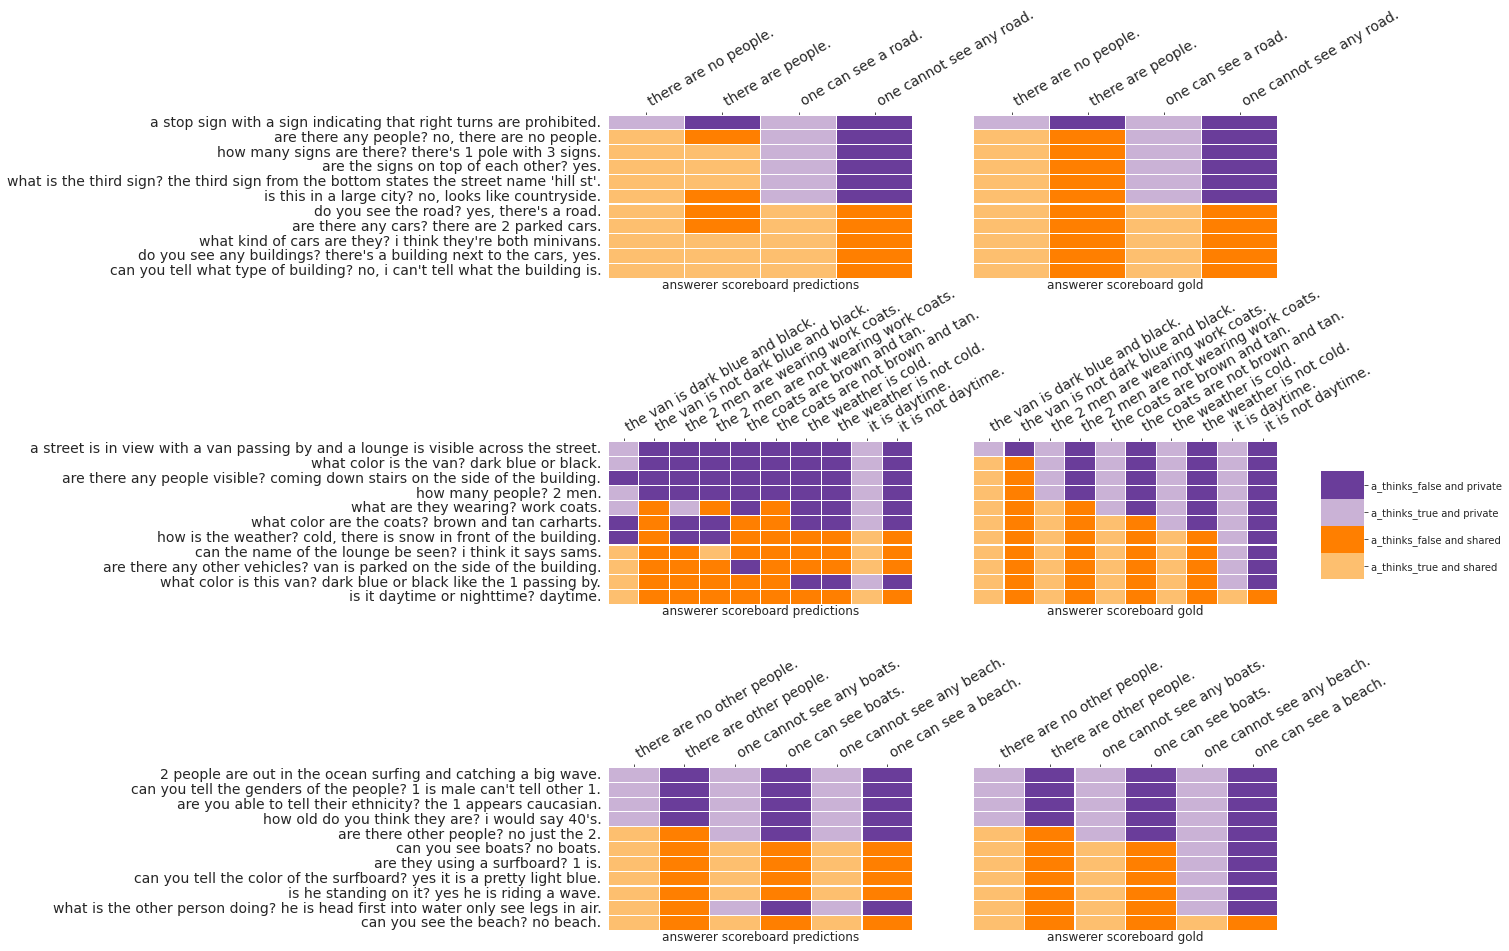

In [54]:
dials = dialogues[(TASK, 'none')]
title = 'answerer scoreboard'

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
cbar_ax = fig.add_axes([.95, .45, .05, .1])

for k, ID in enumerate(IDS):
    (ax1, ax2) = axes[k]
    d_outputs = next(d for d in dials.values() if d.dialogue_id == ID)

    caption, turns = ev.get_vd_dialogue(ID, visdial[split])
    props = [(i, p['proposition']) for i, p in props_data[split][str(ID)].items()]
    types = [caption, *turns]

    df_pred = pd.DataFrame(data=d_outputs.scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])
    df_gold = pd.DataFrame(data=d_outputs.gold_scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])

    vmap = {k: data[TASK].label_names[k] for k in range(4)}
    n = len(vmap)

    custom_palette = sns.color_palette("Paired")[6:6+n]

    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_title(title + ' predictions', y=-0.1)
    matrix = sns.heatmap(df_pred.transpose(), annot=False, cmap=custom_palette, ax=ax1, cbar=False, linewidths=0.1)
    matrix.set_xticklabels(matrix.get_xticklabels(), rotation=30, ha='left', fontsize=14)
    ax1.set_yticklabels(labels=ax1.get_yticklabels(), va='center', fontsize=14)

    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.set_title(title + ' gold', y=-0.1)
    matrix2 = sns.heatmap(df_gold.transpose(), annot=False, cmap=custom_palette, ax=ax2, cbar_ax=cbar_ax, linewidths=0.1)
    matrix2.set_xticklabels(matrix.get_xticklabels(), rotation=30, ha='left', fontsize=14)
    ax2.set_yticklabels(labels=[])

    # https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
    colorbar = ax2.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
    colorbar.set_ticklabels(list(vmap.values()))
    #colorbar.ax.tick_params(labelsize=12)
    
#plt.savefig('assets_for_paper/full-scoreboards-examples.pdf', bbox_inches="tight")
plt.show()

We don't need the gold plots for the paper.

In [55]:
random.seed(274)
IDS = random.sample(range(2061), 6)

In [56]:
change_label_names = {
    'a_thinks_true and shared': 'true to A / shared',
    'a_thinks_false and shared': 'false to A / shared',
    'a_thinks_true and private': 'true to A / private',
    'a_thinks_false and private': 'false to A / private'
}

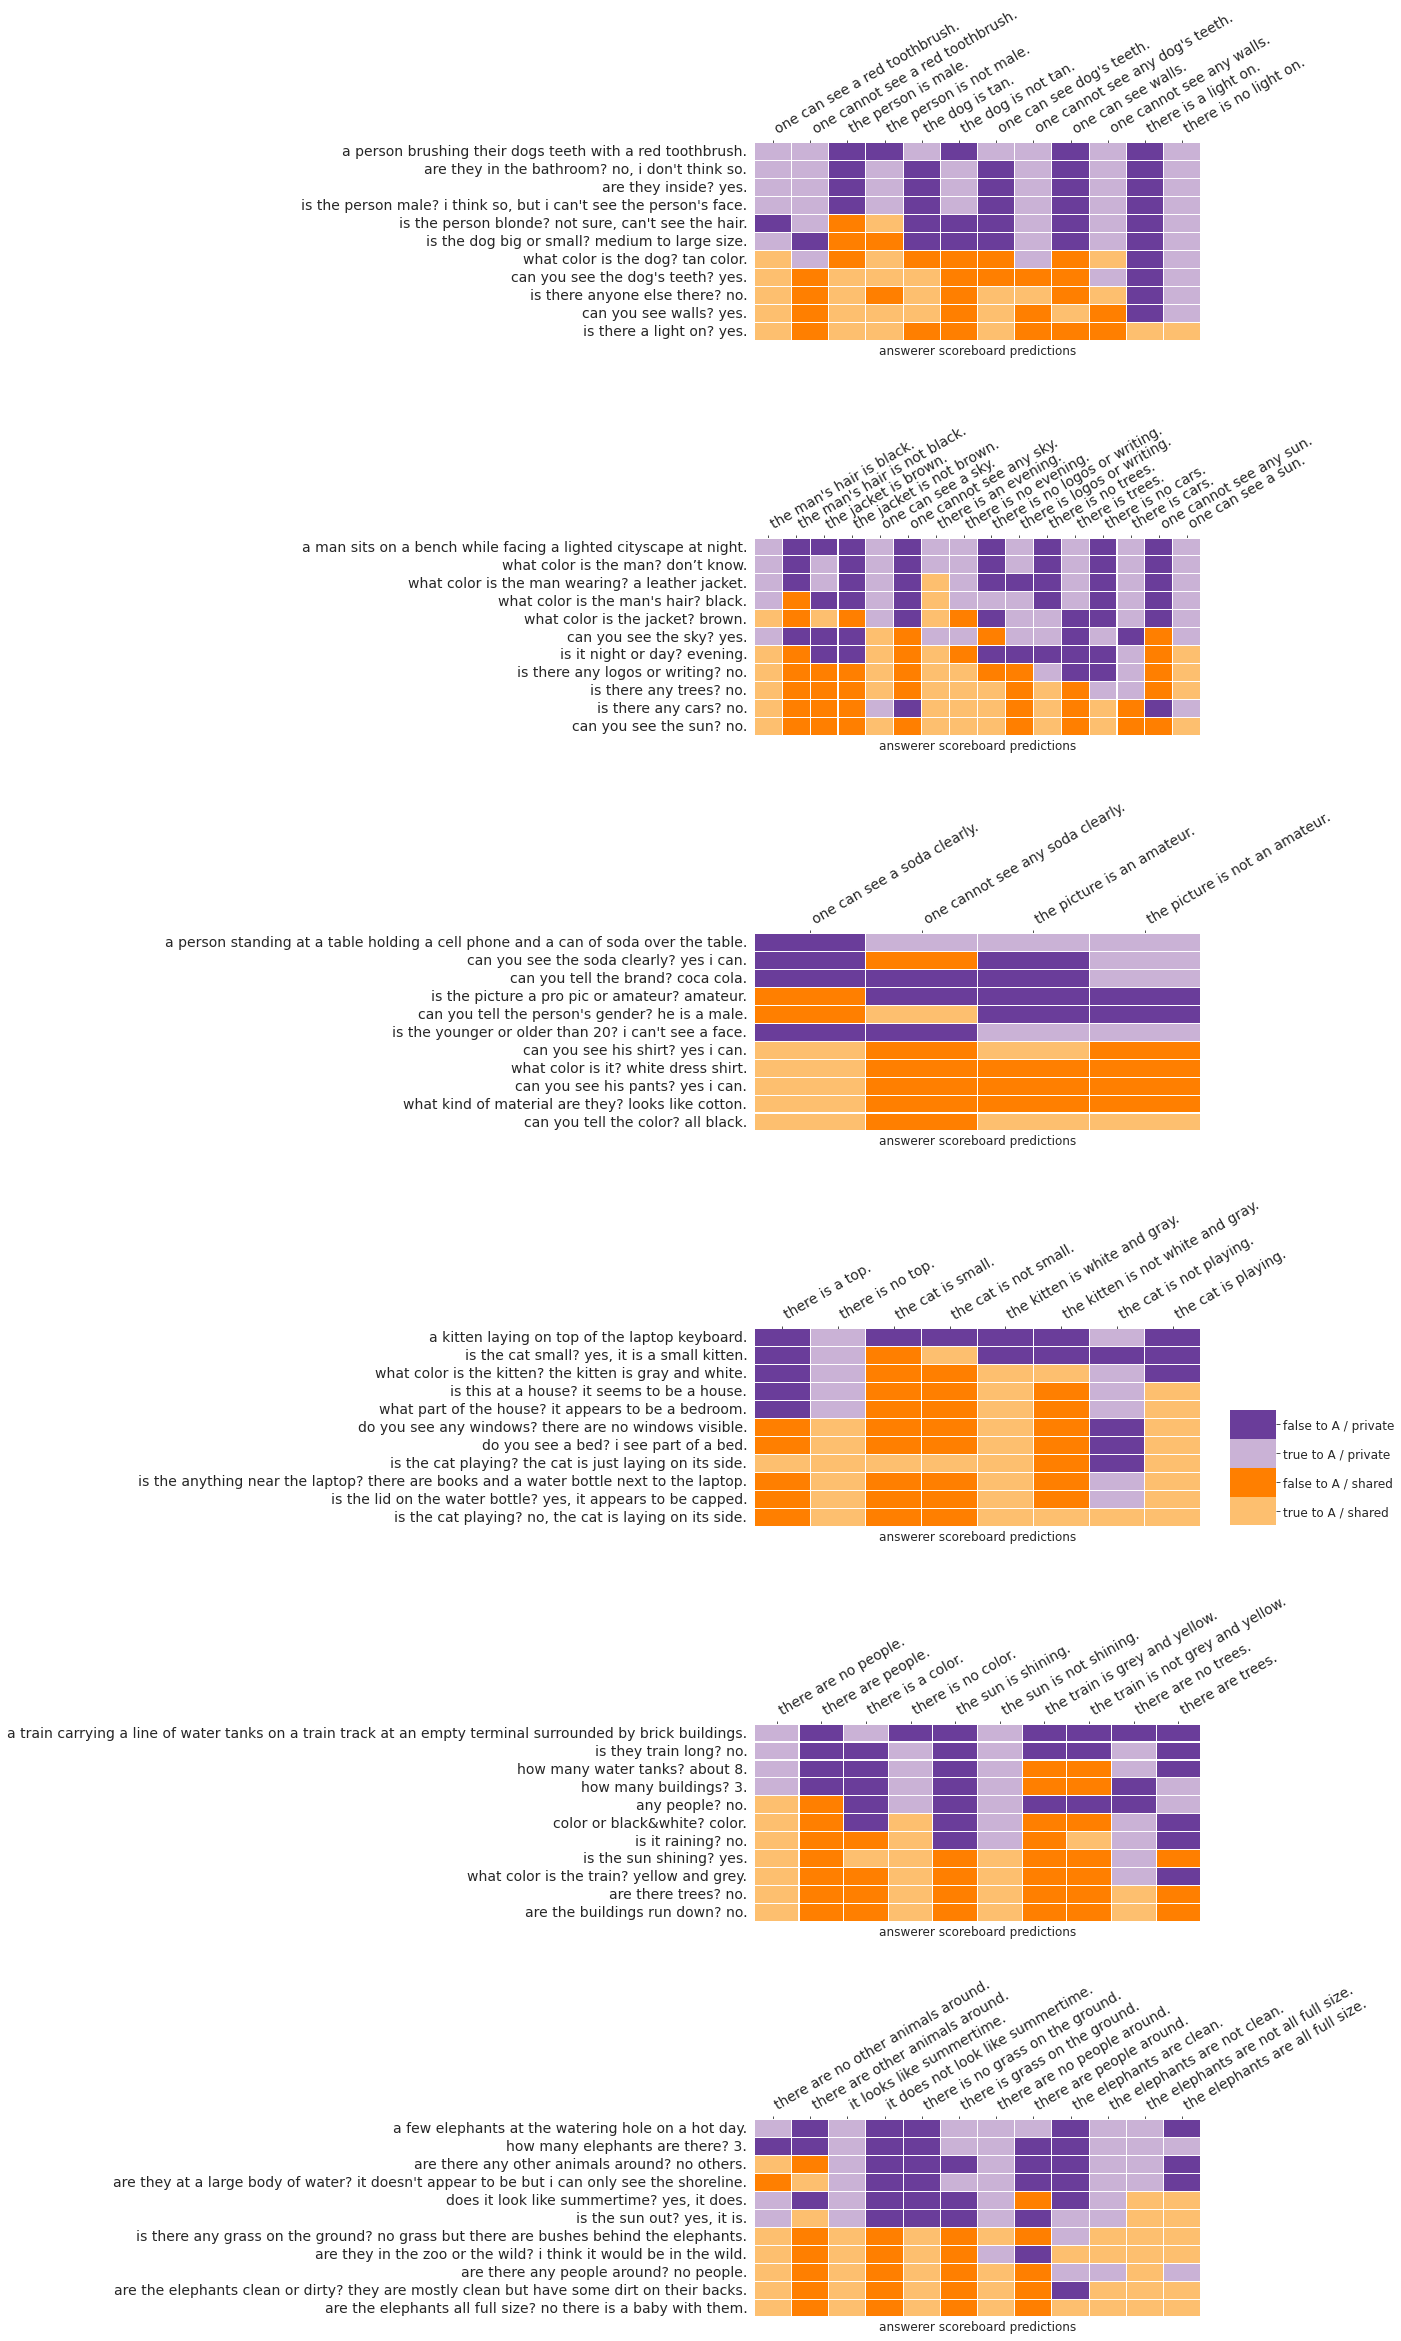

In [57]:
dials = dialogues[(TASK, 'none')]
title = 'answerer scoreboard'

fig, axes = plt.subplots(6, 1, figsize=(8, 40))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
cbar_ax = fig.add_axes([.95, .40, .08, .04])

for k, ID in enumerate(IDS):
    ax1 = axes[k]
    d_outputs = next(d for d in dials.values() if d.dialogue_id == ID)

    caption, turns = ev.get_vd_dialogue(ID, visdial[split])
    props = [(i, p['proposition']) for i, p in props_data[split][str(ID)].items()]
    types = [caption, *turns]

    df_pred = pd.DataFrame(data=d_outputs.scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])
    
    vmap = {k: change_label_names[data[TASK].label_names[k]] for k in range(4)}
    
    n = len(vmap)

    custom_palette = sns.color_palette("Paired")[6:6+n]

    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_title(title + ' predictions', y=-0.1)
    matrix = sns.heatmap(df_pred.transpose(), annot=False, cmap=custom_palette, ax=ax1, cbar_ax=cbar_ax, linewidths=0.1)
    matrix.set_xticklabels(matrix.get_xticklabels(), rotation=30, ha='left', fontsize=14)
    ax1.set_yticklabels(labels=ax1.get_yticklabels(), va='center', fontsize=14)

    # https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
    colorbar = ax1.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
    colorbar.set_ticklabels(list(vmap.values()))
    colorbar.ax.tick_params(labelsize=12)
    
plt.savefig('assets_for_paper/full-scoreboards-examples.pdf', bbox_inches="tight")
plt.show()

Plotting only one for the error analysis:

In [58]:
random.seed(233)

In [59]:
ID = random.sample(range(2061), 1)[0]

In [60]:
print(ID)

714


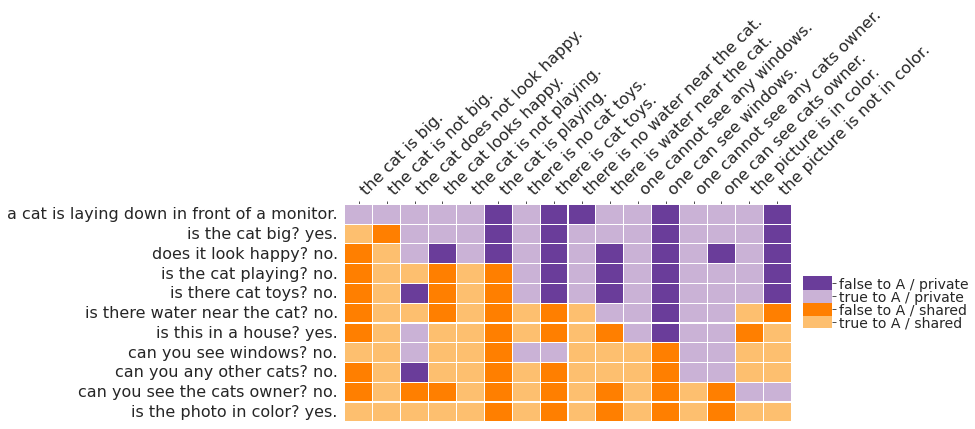

In [61]:
dials = dialogues[(TASK, 'none')]
title = 'answerer scoreboard'

fig, axes = plt.subplots(1, 1, figsize=(8, 4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
cbar_ax = fig.add_axes([.92, .45, .05, .18])

ax1 = axes
d_outputs = next(d for d in dials.values() if d.dialogue_id == ID)

caption, turns = ev.get_vd_dialogue(ID, visdial[split])
props = [(i, p['proposition']) for i, p in props_data[split][str(ID)].items()]
types = [caption, *turns]

df_pred = pd.DataFrame(data=d_outputs.scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])

vmap = {k: change_label_names[data[TASK].label_names[k]].replace(' and ', '/') for k in range(4)}
n = len(vmap)

custom_palette = sns.color_palette("Paired")[6:6+n]

ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
#ax1.set_title(title + ' predictions', y=-0.1)
matrix = sns.heatmap(df_pred.transpose(), annot=False, cmap=custom_palette, ax=ax1, cbar_ax=cbar_ax, linewidths=0.1)
matrix.set_xticklabels(matrix.get_xticklabels(), rotation=45, ha='left', fontsize=16)
ax1.set_yticklabels(labels=ax1.get_yticklabels(), va='center', fontsize=16)

# https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
colorbar = ax1.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
colorbar.ax.tick_params(labelsize=14)
    
plt.savefig('assets_for_paper/errors-examples.pdf', bbox_inches="tight")
plt.show()

Examining many dialogues at once:

In [62]:
random.seed(21203)

In [63]:
IDS = random.sample(range(2061), 24)

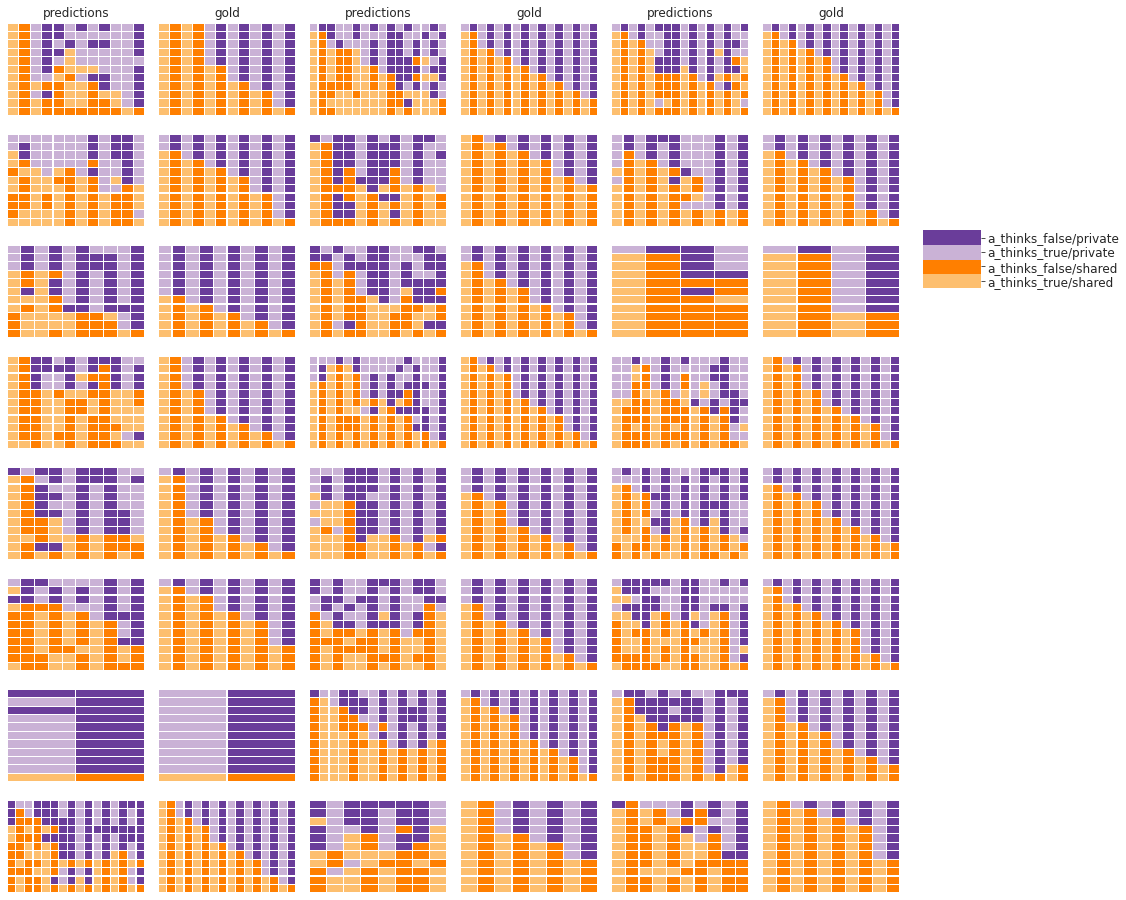

In [64]:
fig, axes = plt.subplots(8, 6, figsize=(16, 16), sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
cbar_ax = fig.add_axes([.92, .65, .05, .05]) # [.92, .47, .05, .05]

all_ax = iter(axes.flatten())

for i, ID in enumerate(IDS):

    dials = dialogues[(TASK, 'none')]
    title = 'predictions'

    ax = next(all_ax)
    d_outputs = next(d for d in dials.values() if d.dialogue_id == ID)

    types = [caption, *turns]

    df_pred = pd.DataFrame(data=d_outputs.scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])
    df_gold = pd.DataFrame(data=d_outputs.gold_scoreboard, columns=types, index=[p.sentence for p in d_outputs.propositions])

    vmap = {k: data[TASK].label_names[k].replace(' and ', '/') for k in range(4)}
    n = len(vmap)

    custom_palette = sns.color_palette("Paired")[6:6+n]

    if i in (0, 1, 2):
        ax.set_title(title)

    if i == len(IDS) - 1 and title == 'predictions':
        matrix = sns.heatmap(df_pred.transpose(), annot=False, cmap=custom_palette, ax=ax, cbar_ax=cbar_ax, linewidths=0.1)

        # https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
        colorbar = ax.collections[0].colorbar
        r = colorbar.vmax - colorbar.vmin
        colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
        colorbar.set_ticklabels(list(vmap.values()))
        colorbar.ax.tick_params(labelsize=12)
    else:
        matrix = sns.heatmap(df_pred.transpose(), annot=False, cmap=custom_palette, ax=ax, cbar=False, linewidths=0.1)

    matrix.set_xticklabels([])
    matrix.set_yticklabels([])

    ax = next(all_ax)
    if i in (0, 1, 2):
        ax.set_title('gold')
    matrix = sns.heatmap(df_gold.transpose(), annot=False, cmap=custom_palette, ax=ax, cbar=False, linewidths=0.1)
    matrix.set_xticklabels([])
    matrix.set_yticklabels([])
    
#plt.savefig('assets_for_paper/many-scoreboards-examples.pdf', bbox_inches="tight")            
plt.show()

## Checking performance per proposition type

In [65]:
results_per_sentence = {p.sentence: {'right': 0, 'total': 0} for p in probes[(TASK, CONTROL)].values()}

In [66]:
for p in probes[(TASK, CONTROL)].values():
    results_per_sentence[p.sentence]['right'] += sum(p.predictions == p.gold)
    results_per_sentence[p.sentence]['total'] += len(p.predictions)

acc_per_sentence = {}
for sentence, counts in results_per_sentence.items():
    acc_per_sentence[sentence] = counts['right'] / counts['total']

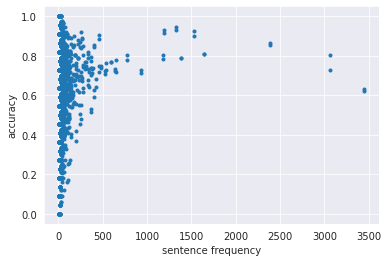

In [67]:
x, y = zip(*[(results_per_sentence[s]['total'], acc_per_sentence[s]) for s in results_per_sentence.keys()])

plt.plot(x, y, '.')
plt.xlabel('sentence frequency')
plt.ylabel('accuracy')
plt.show()

Checking performance on each sentence:

In [68]:
# from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
sorted_dic = dict(sorted(acc_per_sentence.items(), key=lambda x: x[1], reverse=True))
sorted_dic

{'there is no computer chair.': 1.0,
 'there are tattoos.': 1.0,
 'the bowls are not orange.': 1.0,
 "there are tree's or grass.": 1.0,
 "there are no tree's or grass.": 1.0,
 'the 2 buildings are big.': 1.0,
 'the 2 buildings are not big.': 1.0,
 'the man holding a disk is not wearing a hat.': 1.0,
 'the lots of boats are not sail boats.': 1.0,
 'there are no broken pieces of the toilet on the ground.': 1.0,
 'the kitchen is not visible.': 1.0,
 'the kitchen is visible.': 1.0,
 'it looks old.': 1.0,
 'one can see a tree through the window.': 1.0,
 'one cannot see any other houses around.': 1.0,
 'one can see other houses around.': 1.0,
 'there is a cow.': 1.0,
 'there is no cow.': 1.0,
 'the photo is not professional.': 1.0,
 'one can see a sky in the picture.': 1.0,
 'one cannot see any screen.': 1.0,
 'the wine is white.': 1.0,
 'the toothbrushes are not red and blue.': 1.0,
 'the sink is not visible.': 1.0,
 'the sink is visible.': 1.0,
 'a cabinet is visible.': 1.0,
 'the tile is 

Check which of them appeared on the training set:

In [69]:
path_props_train = Path(PATH, PROPS, 'propositions_train.json')
with open(path_props_train, 'r') as f:
    props_data['train'] = json.load(f)['dialogues']

In [70]:
train_sentences = set([p['proposition'] for dialogue in props_data['train'].values() for p in dialogue.values()])

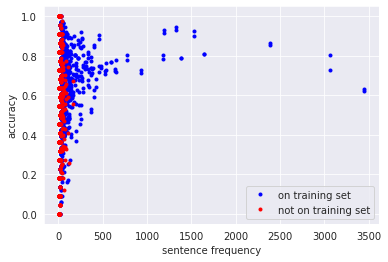

In [71]:
x_in, y_in = zip(*[(results_per_sentence[s]['total'], acc_per_sentence[s]) 
                   for s in results_per_sentence.keys() if s in train_sentences])
plt.plot(x_in, y_in, '.', c='blue', label='on training set')

x_out, y_out = zip(*[(results_per_sentence[s]['total'], acc_per_sentence[s]) 
                     for s in results_per_sentence.keys() if s not in train_sentences])
plt.plot(x_out, y_out, '.', c='red', label='not on training set')
plt.xlabel('sentence frequency')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [72]:
right_on = 0
right_out = 0
total_on = 0 
total_out = 0

for s, counts in results_per_sentence.items():
    if s in train_sentences:
        right_on += counts['right']
        total_on += counts['total']
    else:
        right_out += counts['right']
        total_out += counts['total']

In [73]:
print(f'Accuracy over sentences that appear on the training set is {100*right_on/total_on} and accuracy over sentences that do not appear on the training set is {100*right_out/total_out}.') 

Accuracy over sentences that appear on the training set is 67.69768328842629 and accuracy over sentences that do not appear on the training set is 53.11738490922263.


Sanity check that it's the same number as in the table above:

In [74]:
100*(right_on + right_out) / (total_on + total_out)

62.46116849325869

Sanity check that accuracy over dialogue turns is different because it's a mean of means with different lengths:

In [75]:
for task in TASKS:
    right_at_5 = 0
    total = 0
    accs = []
    for d in dialogues[(task, 'none')].values():
        correct_pred = sum(d.scoreboard[:, 5] == d.gold_scoreboard[:, 5])
        right_at_5 += correct_pred
        total += d.scoreboard.shape[0]
        accs.append(correct_pred / d.scoreboard.shape[0])
    print(f'Acc at turn 5 for task {task} is {right_at_5 / total} and mean over means in {np.mean(accs)}')

Acc at turn 5 for task TFxPS is 0.5797918473547268 and mean over means in 0.5816135123929465
Acc at turn 5 for task TF is 0.7032090199479618 and mean over means in 0.7031715484279911
Acc at turn 5 for task PS is 0.7631396357328708 and mean over means in 0.7638763663207826
Acc at turn 5 for task PxTSFS is 0.6813096270598439 and mean over means in 0.68215661927764
